# Crop Yield Prediction - Deep Learning

Use NUTS3 input data to produce NUTS3 crop yield forecasts. Aggregate forecasts to NUTS2 level and train model using weak supervision from NUTS2 yield statistics.

In [ ]:
test_env = 'notebook'
if (test_env == 'notebook'):
  !pip install d2l==0.16.1 >/dev/null

  from d2l import torch as d2l
  import numpy as np
  import torch
  from torch import nn
  import pandas as pd
  import matplotlib.pyplot as plt
  %matplotlib inline
  plt.rcParams['figure.figsize'] = [30,25]
  plt.rcParams.update({'font.size': 12})

  !pip install pyspark > /dev/null
  !sudo apt update > /dev/null
  !apt-get install openjdk-8-jdk-headless -qq > /dev/null
  !pip install joblibspark > /dev/null

  import os
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
else:  
  import findspark
  findspark.init()

import pyspark
from pyspark.sql import functions as SparkF
from pyspark.sql import types as SparkT

from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

SparkContext.setSystemProperty('spark.executor.memory', '12g')
SparkContext.setSystemProperty('spark.driver.memory', '6g')
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

# crop name to id mapping
crop_id_dict = {
    'grain maize': 2,
    'sugar beet' : 6,
    'sugarbeet' : 6,
    'sugarbeets' : 6,
    'sugar beets' : 6,
    'total potatoes' : 7,
    'potatoes' : 7,
    'potato' : 7,
    'winter wheat' : 90,
    'soft wheat' : 90,
    'sunflower' : 93,
    'spring barley' : 95,
}

# crop id to name mapping
crop_name_dict = {
    2 : 'grain maize',
    6 : 'sugarbeet',
    7 : 'potatoes',
    90 : 'soft wheat',
    93 : 'sunflower',
    95 : 'spring barley',
}

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


## Utility Functions

In [ ]:
import sklearn
from sklearn.metrics import mean_squared_error

from pyspark.sql import Window

# crop name and id mappings
def cropNameToID(crop_id_dict, crop):
  """
  Return id of given crop. Relies on crop_id_dict.
  Return 0 if crop name is not in the dictionary.
  """
  crop_lcase = crop.lower()
  try:
    crop_id = crop_id_dict[crop_lcase]
  except KeyError as e:
    crop_id = 0

  return crop_id

def cropIDToName(crop_name_dict, crop_id):
  """
  Return crop name for given crop ID. Relies on crop_name_dict.
  Return 'NA' if crop id is not found in the dictionary.
  """
  try:
    crop_name = crop_name_dict[crop_id]
  except KeyError as e:
    crop_name = 'NA'

  return crop_name

def getYear(date_str):
  """Extract year from date in yyyyMMdd or dd/MM/yyyy format."""
  return SparkF.when(SparkF.length(date_str) == 8,
                     SparkF.year(SparkF.to_date(date_str, 'yyyyMMdd')))\
                     .otherwise(SparkF.year(SparkF.to_date(date_str, 'dd/MM/yyyy')))

def getMonth(date_str):
  """Extract month from date in yyyyMMdd or dd/MM/yyyy format."""
  return SparkF.when(SparkF.length(date_str) == 8,
                     SparkF.month(SparkF.to_date(date_str, 'yyyyMMdd')))\
                     .otherwise(SparkF.month(SparkF.to_date(date_str, 'dd/MM/yyyy')))

def getDay(date_str):
  """Extract day from date in yyyyMMdd or dd/MM/yyyy format."""
  return SparkF.when(SparkF.length(date_str) == 8,
                     SparkF.dayofmonth(SparkF.to_date(date_str, 'yyyyMMdd')))\
                     .otherwise(SparkF.dayofmonth(SparkF.to_date(date_str, 'dd/MM/yyyy')))

# 1-10: Dekad 1
# 11-20: Dekad 2
# > 20 : Dekad 3
def getDekad(date_str):
  """Extract dekad from date in YYYYMMDD format."""
  month = getMonth(date_str)
  day = getDay(date_str)
  return SparkF.when(day < 30, (month - 1)* 3 +
                     SparkF.ceil(day/10)).otherwise((month - 1) * 3 + 3)

def getFilename(crop, yield_trend, early_season_end,
                country=None, spatial_level=None, architecture=None):
  """Get filename based on input arguments"""
  suffix = crop.replace(' ', '_')

  if (country is not None):
    suffix += '_' + country

  if (spatial_level is not None):
    suffix += '_' + spatial_level

  if (yield_trend):
    suffix += '_trend'
  else:
    suffix += '_notrend'

  if (early_season_end < 0):
    suffix += '_early' + str(early_season_end)

  if (architecture is not None):
    suffix += '-' + architecture

  return suffix

def getLogFilename(crop, yield_trend, early_season_end,
                   country=None, architecture=None):
  """Get filename for experiment log"""
  log_file = getFilename(crop, yield_trend, early_season_end,
                         country=country,
                         architecture=architecture)
  return log_file + '.log'

def getPredictionFilename(crop, yield_trend, early_season_end,
                          country=None, spatial_level=None, architecture=None):
  """Get unique filename for predictions"""
  pred_file = 'pred_'
  suffix = getFilename(crop, yield_trend, early_season_end,
                       country=country,
                       spatial_level=spatial_level,
                       architecture=architecture)
  pred_file += suffix
  return pred_file

def printConfig(cyp_config, log_fh=None):
  config_str = '\nCurrent DL Configuration'
  config_str += '\n-------------------------'
  for k in cyp_config:
    conf_val = cyp_config[k]
    if (not isinstance(conf_val, str)):
      conf_val = str(conf_val)

    config_str += '\n' + k + ': ' + conf_val
  
  config_str += '\n'
  if (log_fh is not None):
    log_fh.write(config_str)

  print(config_str)

def printPreprocessingInformation(df, data_source, id_cols,
                                  order_cols, crop_season=None):
  """Print preprocessed data and additional debug information"""
  df_regions = [reg[0] for reg in df.select(id_cols).distinct().collect()]
  print(data_source , 'data available for', len(df_regions), 'region(s)')
  if (crop_season is not None):
    print('Season end information')
    crop_season.orderBy(id_cols + ['FYEAR']).show(10)

  print(data_source, 'data')
  df.orderBy(order_cols).show(10)

def getTrendWindowYields(df, id_col, trend_window):
  """Extract previous years' yield values to separate columns"""
  sel_cols = [id_col, 'FYEAR', 'YIELD']
  my_window = Window.partitionBy(id_col).orderBy('FYEAR')

  yield_fts = df.select(sel_cols)
  for i in range(trend_window):
    yield_fts = yield_fts.withColumn('YIELD-' + str(i+1),
                                     SparkF.lag(yield_fts.YIELD, i+1).over(my_window))
    yield_fts = yield_fts.withColumn('YEAR-' + str(i+1),
                                     SparkF.lag(yield_fts.FYEAR, i+1).over(my_window))

  # drop columns withs null values
  for i in range(trend_window):
    yield_fts = yield_fts.filter(SparkF.col('YIELD-' + str(i+1)).isNotNull())

  prev_yields = [ 'YIELD-' + str(i) for i in range(trend_window, 0, -1)]
  prev_years = [ 'YEAR-' + str(i) for i in range(trend_window, 0, -1)]
  sel_cols = [id_col, 'FYEAR'] + prev_years + prev_yields
  yield_fts = yield_fts.select(sel_cols)

  return yield_fts

def getNumericIDS(src_df, reg_id_col, num_id_col):
  """Assigns monotonically increasing unique ids to NUTS regions"""
  id_df = src_df.select(reg_id_col).distinct().orderBy(reg_id_col)
  id_df = id_df.withColumn(num_id_col, SparkF.monotonically_increasing_id())

  return id_df

def NormalizedRMSE(y_true, y_pred):
  y_true = y_true.astype('float32')
  y_pred = y_pred.astype('float32')
  return 100 * np.sqrt(mean_squared_error(y_true, y_pred))/np.mean(y_true)

## Data Preprocessor Class

In [ ]:
from pyspark.sql import Window

class CYPDataPreprocessor:
  def __init__(self, spark):
    self.spark = spark
    self.verbose = 1

  def extractYearDekad(self, df):
    """Extract year and dekad from date_col in yyyyMMdd format."""
    # Conversion to string type is required to make getYear(), getMonth() etc. work correctly.
    # They use to_date() function to verify valid dates and to_date() expects the date column to be string.
    df = df.withColumn('DATE', df['DATE'].cast("string"))
    df = df.select('*',
                   getYear('DATE').alias('FYEAR'),
                   getDekad('DATE').alias('DEKAD'))

    # Bring FYEAR, DEKAD to the front
    col_order = df.columns[:2] + df.columns[-2:] + df.columns[2:-2]
    df = df.select(col_order).drop('DATE')
    return df

  def getCropSeasonInformation(self, wofost_df, id_cols,
                               season_crosses_calyear):
    """Crop season information based on WOFOST DVS"""
    join_cols = id_cols + ['FYEAR']
    if (('DATE' in wofost_df.columns) and ('FYEAR' not in wofost_df.columns)):
      wofost_df = self.extractYearDekad(wofost_df)

    crop_season = wofost_df.select(join_cols).distinct()
    diff_window = Window.partitionBy(join_cols).orderBy('DEKAD')
    cs_window = Window.partitionBy(id_cols).orderBy('FYEAR')

    wofost_df = wofost_df.withColumn('VALUE', wofost_df['DVS'])
    wofost_df = wofost_df.withColumn('PREV', SparkF.lag(wofost_df['VALUE']).over(diff_window))
    wofost_df = wofost_df.withColumn('DIFF', SparkF.when(SparkF.isnull(wofost_df['PREV']), 0)\
                                     .otherwise(wofost_df['VALUE'] - wofost_df['PREV']))
    # calculate end of season dekad
    dvs_nochange_filter = ((wofost_df['VALUE'] >= 200) & (wofost_df['DIFF'] == 0.0))
    year_end_filter = (wofost_df['DEKAD'] == 36)
    if (season_crosses_calyear):
      value_zero_filter =  (wofost_df['VALUE'] == 0)
    else:
      value_zero_filter =  ((wofost_df['PREV'] >= 200) & (wofost_df['VALUE'] == 0))

    end_season_filter = (dvs_nochange_filter | value_zero_filter | year_end_filter)
    crop_season = crop_season.join(wofost_df.filter(end_season_filter).groupBy(join_cols)\
                                   .agg(SparkF.min('DEKAD').alias('SEASON_END_DEKAD')), join_cols)
    wofost_df = wofost_df.drop('VALUE', 'PREV', 'DIFF')

    # We take the max of SEASON_END_DEKAD for current campaign and next campaign
    # to determine which dekads go to next campaign year.
    max_year = crop_season.agg(SparkF.max('FYEAR')).collect()[0][0]
    min_year = crop_season.agg(SparkF.min('FYEAR')).collect()[0][0]
    crop_season = crop_season.withColumn('NEXT_SEASON_END', SparkF.when(crop_season['FYEAR'] == max_year,
                                                                        crop_season['SEASON_END_DEKAD'])\
                                         .otherwise(SparkF.lead(crop_season['SEASON_END_DEKAD']).over(cs_window)))
    crop_season = crop_season.withColumn('SEASON_END',
                                         SparkF.when(crop_season['SEASON_END_DEKAD'] > crop_season['NEXT_SEASON_END'],
                                                     crop_season['SEASON_END_DEKAD'])\
                                         .otherwise(crop_season['NEXT_SEASON_END']))
    crop_season = crop_season.withColumn('PREV_SEASON_END', SparkF.when(crop_season['FYEAR'] == min_year, 0)\
                                         .otherwise(SparkF.lag(crop_season['SEASON_END']).over(cs_window)))
    crop_season = crop_season.select(join_cols + ['PREV_SEASON_END', 'SEASON_END'])

    return crop_season

  def alignDataToCropSeason(self, df, id_cols, crop_season,
                            season_crosses_calyear):
    """Calculate CAMPAIGN_YEAR, CAMPAIGN_DEKAD based on crop_season"""
    join_cols = id_cols + ['FYEAR']
    max_year = crop_season.agg(SparkF.max('FYEAR')).collect()[0][0]
    min_year = crop_season.agg(SparkF.min('FYEAR')).collect()[0][0]
    df = df.join(crop_season, join_cols)

    # Dekads > SEASON_END belong to next campaign year
    df = df.withColumn('CAMPAIGN_YEAR',
                       SparkF.when(df['DEKAD'] > df['SEASON_END'], df['FYEAR'] + 1)\
                       .otherwise(df['FYEAR']))
    # min_year has no previous season information. We align CAMPAIGN_DEKAD to end in 36.
    # For other years, dekads < SEASON_END are adjusted based on PREV_SEASON_END.
    # Dekads > SEASON_END get renumbered from 1 (for next campaign).
    df = df.withColumn('CAMPAIGN_DEKAD',
                       SparkF.when(df['CAMPAIGN_YEAR'] == min_year, df['DEKAD'] + 36 - df['SEASON_END'])\
                       .otherwise(SparkF.when(df['DEKAD'] > df['SEASON_END'], df['DEKAD'] - df['SEASON_END'])\
                                  .otherwise(df['DEKAD'] + 36 - df['PREV_SEASON_END'])))

    # Columns should be id_cols, FYEAR, DEKAD, ..., CAMPAIGN_YEAR, CAMPAIGN_DEKAD.
    # Bring CAMPAIGN_YEAR and CAMPAIGN_DEKAD to the front.
    col_order = df.columns[:len(id_cols) + 2] + df.columns[-2:] + df.columns[len(id_cols) + 2:-2]
    df = df.select(col_order)
    if (season_crosses_calyear):
      # For crop with two seasons, remove the first year. Data from the first year
      # only contributes to the second year and we have already moved useful data
      # to the second year (or first campaign year).
      df = df.filter(df['CAMPAIGN_YEAR'] > min_year)

    # In both cases, remove extra rows beyond max campaign year
    df = df.filter(df['CAMPAIGN_YEAR'] <= max_year)
    return df

  def preprocessWofost(self, wofost_df, id_cols,
                       crop_season, season_crosses_calyear):
    """
    Extract year and dekad from date. Use crop_season to compute
    CAMPAIGN_YEAR and CAMPAIGN_DEKAD.
    """
    drop_cols = crop_season.columns[len(id_cols) + 1:]
    if (('DATE' in wofost_df.columns) and ('FYEAR' not in wofost_df.columns)):
      wofost_df = self.extractYearDekad(wofost_df)

    wofost_df = self.alignDataToCropSeason(wofost_df, id_cols,
                                           crop_season, season_crosses_calyear)

    # WOFOST indicators come after id_cols, FYEAR, DEKAD, CAMPAIGN_YEAR, CAMPAIGN_DEKAD.
    indicators_idx = len(id_cols) + 4
    wofost_inds = wofost_df.columns[indicators_idx:]
    # set indicators values for dekads after end of season to zero.
    # TODO - Dilli: Find a way to avoid the for loop.
    for ind in wofost_inds:
      wofost_df = wofost_df.withColumn(ind,
                                       SparkF.when(wofost_df['DEKAD'] < wofost_df['SEASON_END'],
                                                   wofost_df[ind])\
                                       .otherwise(0))

    wofost_df = wofost_df.drop(*drop_cols)
    return wofost_df

  def preprocessMeteo(self, meteo_df, id_cols,
                      crop_season, season_crosses_calyear):
    """
    Extract year and dekad from date, calculate CWB.
    Use crop_season to compute CAMPAIGN_YEAR and CAMPAIGN_DEKAD.
    """
    drop_cols = crop_season.columns[len(id_cols) + 1:]
    meteo_df = meteo_df.drop('IDCOVER')
    meteo_df = meteo_df.withColumn('CWB',
                                   SparkF.bround(meteo_df['PREC'] - meteo_df['ET0'], 2))
    if (('DATE' in meteo_df.columns) and ('FYEAR' not in meteo_df.columns)):
      meteo_df = self.extractYearDekad(meteo_df)

    meteo_df = self.alignDataToCropSeason(meteo_df, id_cols,
                                          crop_season, season_crosses_calyear)
    meteo_df = meteo_df.drop(*drop_cols)
    return meteo_df

  def preprocessMeteoDaily(self, meteo_df, id_cols):
    """
    Convert daily meteo data to dekadal. Takes avg for all indicators
    except TMAX (take max), TMIN (take min), PREC (take sum), ET0 (take sum), CWB (take sum).
    """
    self.spark.catalog.dropTempView('meteo_daily')
    meteo_df.createOrReplaceTempView('meteo_daily')
    join_cols = id_cols + ['CAMPAIGN_YEAR', 'CAMPAIGN_DEKAD']
    join_df = meteo_df.select(join_cols + ['FYEAR', 'DEKAD']).distinct()

    # We are ignoring VPRES, WSPD and RELH at the moment
    # avg(VPRES) as VPRES1, avg(WSPD) as WSPD1, avg(RELH) as RELH1,
    # TMAX| TMIN| TAVG| VPRES| WSPD| PREC| ET0| RAD| RELH| CWB
    #
    # It seems keeping same name after aggregation is fine. We are using a
    # different name just to be sure nothing untoward happens.
    query = 'select ' + ', '.join(id_cols) + ', CAMPAIGN_YEAR, CAMPAIGN_DEKAD, '
    query = query + ' max(TMAX) as TMAX1, min(TMIN) as TMIN1, '
    query = query + ' bround(avg(TAVG), 2) as TAVG1, bround(sum(PREC), 2) as PREC1, '
    query = query + ' bround(sum(ET0), 2) as ET01, bround(avg(RAD), 2) as RAD1, '
    query = query + ' bround(sum(CWB), 2) as CWB1 from meteo_daily'
    query = query + ' group by ' + ', '.join(id_cols) + ', CAMPAIGN_YEAR, CAMPAIGN_DEKAD '
    query = query + ' order by ' + ', '.join(id_cols) + ', CAMPAIGN_YEAR, CAMPAIGN_DEKAD'
    meteo_df = self.spark.sql(query).cache()

    # rename the columns
    selected_cols = ['TMAX', 'TMIN', 'TAVG', 'PREC', 'ET0', 'RAD', 'CWB']
    for scol in selected_cols:
      meteo_df = meteo_df.withColumnRenamed(scol + '1', scol)

    meteo_df = meteo_df.join(join_df, join_cols)
    # Bring FYEAR, DEKAD to the front
    col_order = meteo_df.columns[:len(id_cols)] + meteo_df.columns[-2:] + meteo_df.columns[len(id_cols):-2]
    meteo_df = meteo_df.select(col_order)

    return meteo_df

  def preprocessRemoteSensing(self, rs_df, id_cols,
                              crop_season, season_crosses_calyear):
    """
    Extract year and dekad from date.
    Use crop_season to compute CAMPAIGN_YEAR and CAMPAIGN_DEKAD.
    NOTE crop_season and rs_df must be at the same NUTS level.
    """
    drop_cols = crop_season.columns[len(id_cols) + 1:]
    if (('DATE' in rs_df.columns) and ('FYEAR' not in rs_df.columns)):
      rs_df = self.extractYearDekad(rs_df)

    rs_df = self.alignDataToCropSeason(rs_df, id_cols,
                                       crop_season, season_crosses_calyear)
    rs_df = rs_df.drop(*drop_cols)
    return rs_df

  def preprocessSoil(self, soil_df, id_cols):
    # SM_WC = water holding capacity
    soil_df = soil_df.withColumn('SM_WHC', SparkF.bround(soil_df['SM_FC'] - soil_df['SM_WP'], 2))
    soil_df = soil_df.select(id_cols + ['SM_WHC'])

    return soil_df

  def preprocessAreaFractions(self, af_df, crop_id):
    """Filter area fractions data by crop id"""
    af_df = af_df.withColumn("FYEAR", af_df["FYEAR"].cast(SparkT.IntegerType()))
    af_df = af_df.filter(af_df["CROP_ID"] == crop_id).drop('CROP_ID')

    return af_df

  def preprocessCropArea(self, area_df, crop_id):
    """Filter area fractions data by crop id"""
    area_df = area_df.withColumn("FYEAR", area_df["FYEAR"].cast(SparkT.IntegerType()))
    area_df = area_df.filter(area_df["CROP_ID"] == crop_id).drop('CROP_ID')
    area_df = area_df.filter(area_df["CROP_AREA"].isNotNull())
    area_df = area_df.drop('FRACTION')

    return area_df

  def preprocessGAES(self, gaes_df, crop_id):
    """Select irrigated crop area by crop id"""
    sel_cols = [ c for c in gaes_df.columns if 'IRRIG' not in c]
    sel_cols += ['IRRIG_AREA_ALL', 'IRRIG_AREA' + str(crop_id)]

    return gaes_df.select(sel_cols)

  def preprocessLabels(self, yield_df, id_col, crop_id):
    """
    Yield preprocessing depends on the data format.
    Here we cover preprocessing for France (NUTS3), Germany (NUTS3) and the Netherlands (NUTS2).
    """
    # Delete trailing empty columns
    empty_cols = [ c for c in yield_df.columns if c.startswith('_c') ]
    for c in empty_cols:
      yield_df = yield_df.drop(c)

    # Special case for Netherlands and Germany: convert yield columns into rows
    years = [int(c) for c in yield_df.columns if c[0].isdigit()]
    if (len(years) > 0):
      yield_by_year = yield_df.rdd.map(lambda x: (x[0], cropNameToID(crop_id_dict, x[0]), x[1],
                                                  [(years[i], x[i+2]) for i in range(len(years))]))

      yield_df = yield_by_year.toDF(['CROP', 'CROP_ID', id_col, 'YIELD'])
      yield_df = yield_df.withColumn('YR_YIELD', SparkF.explode('YIELD')).drop('YIELD')
      yield_by_year = yield_df.rdd.map(lambda x: (x[0], x[1], x[2], x[3][0], x[3][1]))
      yield_df = yield_by_year.toDF(['CROP', 'CROP_ID', id_col, 'FYEAR', 'YIELD'])
    else:
      yield_by_year = yield_df.rdd.map(lambda x: (x[0], cropNameToID(crop_id_dict, x[0]), x[1], x[2], x[3]))
      yield_df = yield_by_year.toDF(['CROP', 'CROP_ID', id_col, 'FYEAR', 'YIELD'])

    yield_df = yield_df.filter(yield_df.CROP_ID == crop_id).drop('CROP', 'CROP_ID')
    if (yield_df.count() == 0):
      return None

    yield_df = yield_df.filter(yield_df.YIELD.isNotNull())
    yield_df = yield_df.withColumn("YIELD", yield_df["YIELD"].cast(SparkT.FloatType()))
    yield_df = yield_df.withColumn("FYEAR", yield_df["FYEAR"].cast(SparkT.IntegerType()))
    yield_df = yield_df.filter(yield_df['YIELD'] > 0.0)

    return yield_df

## Data Loading and Preprocessing

In [ ]:
from datetime import date

def loadDataFromCSVFile(spark, data_path, src, spatial_level, country_code):
    """
    The implied filename for each source is:
    <data_source>_<spatial_level>_<country_code>.csv
    Examples: WOFOST_NUTS2_NL.csv.
    Schema is inferred from the file. We might want to specify the schema at some point.
    """
    if (country_code is not None):
      datafile = data_path + '/' + src  + '_' + spatial_level + '_' + country_code + '.csv'
    elif (spatial_level is not None):
      datafile = data_path + '/' + src  + '_' + spatial_level + '.csv'
    else:
      datafile = data_path + '/' + src  + '.csv'

    print('Data file name', '"' + datafile + '"')

    df = spark.read.csv(datafile, header = True, inferSchema = True)
    return df

def loadAllData(spark, data_sources, data_path='.', country=None):
  #################
  # Load data     #
  #################
  data_dfs = {}
  for src in data_sources:
    spatial_level = data_sources[src]['spatial_level']
    data_dfs[src] = loadDataFromCSVFile(spark, data_path, src, spatial_level, country)

  data_sources_str = ''
  for src in data_dfs:
    data_sources_str = data_sources_str + src + ', '

  # remove the comma and space from the end
  print('Loaded data:', data_sources_str[:-2])
  print('\n')

  return data_dfs

def preprocessData(spark, data_dfs, data_sources,
                   high_res_id_col, low_res_id_col,
                   crop, countries, season_crosses_calyear=False,
                   early_season=False, early_season_end=0, print_debug=False):
  ######################
  # Preprocess Data    #
  ######################
  crop_id = cropNameToID(crop_id_dict, crop)
  cyp_preprocessor = CYPDataPreprocessor(spark)
  crop_season = None
  id_cols = [low_res_id_col, high_res_id_col]
  for src in data_sources:
    src_df = data_dfs[src]
    spatial_level = data_sources[src]['spatial_level']
    if ((spatial_level == 'NUTS2') and
        ('IDREGION' in src_df.columns)):
      src_df = src_df.withColumnRenamed('IDREGION', 'NUTS2_ID')
    elif ((spatial_level == 'NUTS3') and
        ('IDREGION' in src_df.columns) and
        ('NUTS2_ID' not in src_df.columns)):
      sel_cols = ['NUTS2_ID', 'NUTS3_ID'] + [c for c in src_df.columns if c != 'IDREGION']
      src_df = src_df.withColumnRenamed('IDREGION', 'NUTS3_ID')
      src_df = src_df.withColumn('NUTS2_ID', SparkF.substring(src_df['NUTS3_ID'], 1, 4))
      src_df = src_df.select(sel_cols)
    elif ((spatial_level == 'GRIDS') and
          ('IDREGION' in src_df.columns) and
          ('NUTS3_ID' not in src_df.columns)):
      sel_cols = ['NUTS3_ID', 'GRID_ID'] + [c for c in src_df.columns if ((c != 'IDREGION') and
                                                                          ('GRID' not in c))]
      src_df = src_df.withColumnRenamed('IDREGION', 'NUTS3_ID')
      src_df = src_df.select(sel_cols)

    if (src == 'WOFOST'):
      # wofost data
      wofost_df = src_df.filter(src_df['CROP_ID'] == crop_id).drop('CROP_ID')
      wofost_df = wofost_df.filter(SparkF.substring(wofost_df[high_res_id_col], 1, 2).isin(countries))
      crop_season = cyp_preprocessor.getCropSeasonInformation(wofost_df, id_cols,
                                                              season_crosses_calyear)
      wofost_df = cyp_preprocessor.preprocessWofost(wofost_df, id_cols,
                                                    crop_season, season_crosses_calyear)
      data_dfs[src] = wofost_df

    if ('METEO' in src):
      # meteo data
      meteo_df = cyp_preprocessor.preprocessMeteo(src_df, id_cols,
                                                  crop_season, season_crosses_calyear)

      if (src == 'METEO_DAILY'):
        meteo_df = cyp_preprocessor.preprocessMeteoDaily(meteo_df, id_cols)

      assert (meteo_df is not None)
      data_dfs[src] = meteo_df.filter(SparkF.substring(meteo_df[high_res_id_col], 1, 2).isin(countries))

    # remote sensing data
    if (src == 'REMOTE_SENSING'):
      rs_df = src_df.drop('IDCOVER')
      rs_df = cyp_preprocessor.preprocessRemoteSensing(rs_df, id_cols,
                                                       crop_season, season_crosses_calyear)
      assert (rs_df is not None)
      data_dfs[src] = rs_df.filter(SparkF.substring(rs_df[high_res_id_col], 1, 2).isin(countries))

    # soil data
    if (src == 'SOIL'):
      soil_df = cyp_preprocessor.preprocessSoil(src_df, id_cols)
      data_dfs['SOIL'] = soil_df.filter(SparkF.substring(soil_df[high_res_id_col], 1, 2).isin(countries))

    # agro-environmental zones
    if (src == 'GAES'):
      gaes_df = cyp_preprocessor.preprocessGAES(src_df, crop_id)
      data_dfs['GAES'] = gaes_df.filter(SparkF.substring(gaes_df[high_res_id_col], 1, 2).isin(countries))

    # crop area data
    if (src == 'CROP_AREA'):
      crop_area_df = cyp_preprocessor.preprocessCropArea(src_df, crop_id)
      data_dfs['CROP_AREA'] = crop_area_df.filter(SparkF.substring(crop_area_df[low_res_id_col], 1, 2).isin(countries))

    # label data
    if (src == 'YIELD'):
      label_df = cyp_preprocessor.preprocessLabels(src_df, low_res_id_col, crop_id)
      assert (label_df is not None)
      data_dfs['YIELD'] = label_df.filter(SparkF.substring(label_df[low_res_id_col], 1, 2).isin(countries))

  # Print debug information
  for src in data_dfs:
    src_df = data_dfs[src]
    order_cols = data_sources[src]['order_cols']
    if (high_res_id_col in src_df.columns):
      if (src == 'WOFOST' and print_debug):
        printPreprocessingInformation(src_df, src, id_cols,
                                      order_cols, crop_season=crop_season)
      elif (print_debug):
        printPreprocessingInformation(src_df, src, id_cols, order_cols)
    elif (print_debug):
        printPreprocessingInformation(src_df, src, low_res_id_col, order_cols)

  return data_dfs

def getLinearYieldTrend(pd_yield_ft_df, id_cols, trend_window):
  """Fits a linear trend model to yields from 5 previous years"""
  join_cols = id_cols + ['FYEAR']
  region_years = pd_yield_ft_df[join_cols].values
  prev_year_cols = ['YEAR-' + str(i) for i in range(1, trend_window + 1)]
  prev_yield_cols = ['YIELD-' + str(i) for i in range(1, trend_window + 1)]
  window_years = pd_yield_ft_df[prev_year_cols].values
  window_yields = pd_yield_ft_df[prev_yield_cols].values

  yield_trend = []
  for i in range(region_years.shape[0]):
    coefs = np.polyfit(window_years[i, :], window_yields[i, :], 1)
    yield_trend.append(float(np.round(coefs[0] * region_years[i, 1] + coefs[1], 2)))

  pd_yield_ft_df['YIELD_TREND'] = yield_trend
  drop_cols = ['YEAR-' + str(i) for i in range(1, 6)]
  pd_yield_ft_df = pd_yield_ft_df.drop(columns=drop_cols)

  return pd_yield_ft_df

def combineInputData(data_sources, data_dfs, countries,
                     ts_data_sources,
                     static_data_sources,
                     high_res_id_col, low_res_id_col,
                     early_season_end=None,
                     trend_window=5,
                     print_debug=False):
  """Combine dekadal and static data"""
  input_min_year = 1900
  input_max_year = date.today().year
  for src in ts_data_sources:
    input_df = data_dfs[src]
    min_year = input_df.agg(SparkF.min('CAMPAIGN_YEAR')).collect()[0][0]
    max_year = input_df.agg(SparkF.max('CAMPAIGN_YEAR')).collect()[0][0]
    # max of min years (earliest year after join, not min of min)
    if (min_year > input_min_year):
      input_min_year = min_year
    # min of max years (latest year after join, not max of max)
    if (max_year < input_max_year):
      input_max_year = max_year

  # combine dekadal data
  dekadal_df = None
  for src in ts_data_sources:
    input_df = data_dfs[src].select(data_sources[src]['sel_cols'])
    input_df = input_df.filter((input_df['CAMPAIGN_YEAR'] >= input_min_year) &
                               (input_df['CAMPAIGN_YEAR'] <= input_max_year))
    if (dekadal_df is None):
      dekadal_df = input_df
    else:
      dekadal_df = dekadal_df.join(input_df, data_sources[src]['order_cols'], 'full')
      dekadal_df = dekadal_df.na.fill(0.0)

  dekadal_df = dekadal_df.withColumnRenamed('CAMPAIGN_YEAR', 'FYEAR')
  dekadal_df = dekadal_df.withColumnRenamed('CAMPAIGN_DEKAD', 'DEKAD')
  max_dekad = 36
  if (early_season_end is not None):
    # early_season_end is relative to harvest (so 0 or negative)
    max_dekad += early_season_end
    dekadal_df = dekadal_df.filter(dekadal_df['DEKAD'] <= max_dekad)

  static_df = None
  for src in static_data_sources:
    input_df = data_dfs[src].select(data_sources[src]['sel_cols'])
    if (static_df is None):
      static_df = input_df
    else:
      static_df = static_df.join(input_df, data_sources[src]['order_cols'])

  label_df = data_dfs['YIELD']
  crop_area_df = data_dfs['CROP_AREA']

  # get trend feature values: basically values of 5 previous years
  trend_ft_df = getTrendWindowYields(label_df, low_res_id_col, trend_window)
  year_cols = ['YEAR-' + str(i) for i in range(1, trend_window + 1)]
  trend_ft_df = trend_ft_df.drop(*year_cols)

  # Training, test splits are decided based on label years.
  country_years = {}
  label_df = label_df.withColumn('COUNTRY', SparkF.substring(label_df[low_res_id_col], 1, 2))
  for cn in countries:
    label_cn_df = label_df.filter(label_df['COUNTRY'] == cn)
    cn_years = [yr[0] for yr in label_cn_df.select('FYEAR').distinct().collect()]
    country_years[cn] = sorted(cn_years)

  # Align spatial units and years
  label_df = label_df.join(static_df.select(low_res_id_col).distinct(), [low_res_id_col])
  label_df = label_df.join(trend_ft_df.select([low_res_id_col, 'FYEAR']),
                           [low_res_id_col, 'FYEAR'])
  # NOTE: CROP_AREA is added to label_df
  label_df = label_df.join(crop_area_df, [low_res_id_col, 'FYEAR'])

  label_df = label_df.join(dekadal_df.select([low_res_id_col, 'FYEAR']).distinct(),
                           [low_res_id_col, 'FYEAR'])
  label_reg_years = label_df.select([low_res_id_col, 'FYEAR']).distinct()
  trend_ft_df = trend_ft_df.join(label_reg_years, [low_res_id_col, 'FYEAR'])
  dekadal_df = dekadal_df.join(label_reg_years, [low_res_id_col, 'FYEAR'])
  label_regions = label_df.select(low_res_id_col).distinct()
  static_df = static_df.join(label_regions, [low_res_id_col])

  # Create numeric ids for regions and countries
  input_id_df = getNumericIDS(label_df, low_res_id_col, 'id_y')
  label_id_df = getNumericIDS(label_df, low_res_id_col, 'id_y')
  input_id_df = input_id_df.join(static_df.select([low_res_id_col, high_res_id_col]), [low_res_id_col])
  if (high_res_id_col == 'NUTS3_ID'):
    nuts3_id_df = getNumericIDS(input_id_df, high_res_id_col, 'id_x')
    input_id_df = input_id_df.join(nuts3_id_df, high_res_id_col)

  input_id_df = input_id_df.withColumn('COUNTRY', SparkF.substring(input_id_df[high_res_id_col], 1, 2))
  label_id_df = label_id_df.withColumn('COUNTRY', SparkF.substring(label_id_df[low_res_id_col], 1, 2))
  cnid_df = getNumericIDS(label_id_df, 'COUNTRY', 'id0')
  input_id_df = input_id_df.join(cnid_df, ['COUNTRY'])
  label_id_df = label_id_df.join(cnid_df, ['COUNTRY'])

  # Add numeric id columns, remove IDREGION, COUNTRY and reorder columns
  label_num_id_cols = ['id0', 'id_y']
  label_join_cols = [low_res_id_col]
  label_drop_cols = [low_res_id_col, 'COUNTRY']
  if (low_res_id_col == 'NUTS2_ID'):
    input_num_id_cols = ['id0', 'id_y', 'id_x']
    input_join_cols = ['NUTS2_ID', 'NUTS3_ID']
    input_drop_cols = ['NUTS2_ID', 'NUTS3_ID', 'COUNTRY']
  else:
    input_num_id_cols = ['id0', 'id_y', 'GRID_ID']
    input_join_cols = ['NUTS3_ID', 'GRID_ID']
    input_drop_cols = ['NUTS3_ID', 'COUNTRY']

  # Add numeric id columns : DEKADAL
  dekadal_df = dekadal_df.join(input_id_df, input_join_cols).drop(*input_drop_cols)
  dekadal_df = dekadal_df.select(input_num_id_cols + 
                                 [c for c in dekadal_df.columns if c not in input_num_id_cols])
  if (print_debug):
    print('\n')
    print('DEKADAL')
    dekadal_df.orderBy(input_num_id_cols + ['FYEAR', 'DEKAD']).show(10)

  # Add numeric id columns : TREND
  trend_ft_df = trend_ft_df.join(label_id_df, label_join_cols).drop(*label_drop_cols)
  trend_ft_df = trend_ft_df.select(label_num_id_cols +
                                   [c for c in trend_ft_df.columns if c not in label_num_id_cols])
  if (print_debug):
    print('\n')
    print('TREND')
    trend_ft_df.orderBy(label_num_id_cols + ['FYEAR']).show(10)

  # Add numeric id columns : YIELD
  label_df = label_df.drop('COUNTRY')
  label_df = label_df.join(label_id_df, label_join_cols).drop(*label_drop_cols)
  label_df = label_df.select(label_num_id_cols +
                             [c for c in label_df.columns if c not in label_num_id_cols])
  if (print_debug):
    print('\n')
    print('YIELD')
    label_df.orderBy(label_num_id_cols + ['FYEAR']).show(10)

  # Add numeric id columns : STATIC
  # We drop COUNTRY later after getting one-hot encondings
  static_df = static_df.join(input_id_df, input_join_cols).drop(*['NUTS2_ID', 'NUTS3_ID'])
  static_df = static_df.select(input_num_id_cols +
                               [c for c in static_df.columns if c not in input_num_id_cols])
  pd_static_df = static_df.toPandas()
  if (len(pd_static_df['COUNTRY'].unique()) > 1):
    pd_sel_static_df = pd_static_df[['COUNTRY', 'AEZ_ID']].astype({ 'AEZ_ID' : 'str' })
    pd_onehot_df = pd.get_dummies(pd_sel_static_df, prefix=['CN', 'AEZ'])
  else:
    pd_sel_static_df = pd_static_df[['AEZ_ID']].astype({ 'AEZ_ID' : 'str' })
    pd_onehot_df = pd.get_dummies(pd_sel_static_df, prefix=['AEZ'])

  pd_static_df = pd.concat([pd_static_df, pd_onehot_df], axis=1).drop(columns=['COUNTRY', 'AEZ_ID'])
  if (print_debug):
    print('\n')
    print('STATIC')
    print(pd_static_df.sort_values(by=input_num_id_cols).head(10).to_string(index=False))

  if (print_debug):
    print('\n')
    print('NUMERIC_IDS')
    input_id_df.orderBy(input_num_id_cols).show(10)
    label_id_df.orderBy(label_num_id_cols).show(10)

  pd_dekadal_df = dekadal_df.toPandas()
  pd_trend_df = trend_ft_df.toPandas()
  pd_label_df = label_df.toPandas()
  pd_input_id_df = input_id_df.toPandas()
  pd_label_id_df = label_id_df.toPandas()

  combined_dfs = {
      'DEKADAL' : pd_dekadal_df,
      'STATIC' : pd_static_df,
      'YIELD_TREND' : pd_trend_df,
      'YIELD' : pd_label_df,
      'INPUT_NUMERIC_IDS' : pd_input_id_df,
      'LABEL_NUMERIC_IDS' : pd_label_id_df
  }

  return combined_dfs, country_years

## Training, Validation and Test Splits

In [ ]:
import numpy as np

class CYPTrainTestSplitter:
  def __init__(self, verbose=False):
    self.verbose = verbose

  def getTestYears(self, all_years, test_fraction=None, use_yield_trend=None):
    num_years = len(all_years)
    test_years = []
    if (test_fraction is None):
      test_fraction = self.test_fraction

    if (use_yield_trend is None):
      use_yield_trend = self.use_yield_trend

    if (use_yield_trend):
      # If test_year_start 15, years with index >= 15 are added to the test set
      test_year_start = num_years - np.floor(num_years * test_fraction).astype('int')
      test_years = all_years[test_year_start:]
    else:
      # If test_year_pos = 5, every 5th year is added to test set.
      # indices start with 0, so test_year_pos'th year has index (test_year_pos - 1)
      test_year_pos = np.floor(1/test_fraction).astype('int')
      test_years = all_years[test_year_pos - 1::test_year_pos]

    return test_years

  # NOTE Y_train should include region_id, FYEAR as first two columns.
  def getCustomKFoldValidationYears(self, all_years, num_folds=5, num_valid_years=1):
    """
    Custom K-fold Validation Splits:
    When using yield trend, we cannot do k-fold cross-validation. The custom
    K-Fold validation splits data in time-ordered fashion. The test data
    always comes after the training data.
    """
    num_years = len(all_years)
    num_train_years = num_years - (num_valid_years * num_folds)

    custom_split_info = '\nCustom sliding validation train, test splits'
    custom_split_info += '\n----------------------------------------------'

    cv_valid_years = []
    for k in range(num_folds):
      test_years_start = num_train_years + (k * num_valid_years)
      k_train_years = all_years[:test_years_start]
      k_val_years = all_years[test_years_start:test_years_start + num_valid_years]
      cv_valid_years.append(k_val_years)
      k_train_years = [str(y) for y in k_train_years]
      k_val_years = [str(y) for y in k_val_years]
      custom_split_info += '\nValidation set ' + str(k + 1) + ' training years: ' + ', '.join(k_train_years)
      custom_split_info += '\nValidation set ' + str(k + 1) + ' test years: ' + ', '.join(k_val_years)

    custom_split_info += '\n'
    if (self.verbose):
      print(custom_split_info)

    return cv_valid_years

## Dataset Class

In [ ]:
from torch.utils.data import Dataset

# A dataset class for crop yield forecasting data
# A dataset class for crop yield forecasting data
class CYPMLDataset(Dataset):
  """
  Dataset class used to load features and labels for training and testing.
  For more info about writing custom datasets classes check
  https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

  Parameters
  ----------
  data_dfs : dictionary of input dataframes
  yield_trend : data uses yield trend
  early_season_end : early season prediction dekad (relative to harvest)
  is_train : bool to differentiate training, validation and test sets
  is_validation : bool to differentiate between training and validation sets
  test_fraction : fraction of years to use for held-out testing
  num_folds : number of folds for custom cv
  num_valid_years : number of years in validation set
  fold_iter : iteration number of cv
  scaler_args : mean, std values (for each indicator) calculated using training dataset
  country : country code
  """
  def __init__(self, data_dfs, country_years,
               yield_trend=True, early_season_end=None,
               is_train=True, is_validation=False, test_fraction=0.3,
               num_folds=1, num_valid_years=5, fold_iter=0,
               test_years=None, scaler_args=None,
               print_debug=False, log_fh=None):

    if (is_train and print_debug):
      print('\n----------------')
      print('Training data')
      print('----------------')
    elif (is_validation and print_debug):
      print('\n------------------')
      print('Validation data')
      print('------------------')
    elif (print_debug):
      print('\n-------------')
      print('Test data:')
      print('-------------')

    pd_dekadal_df = data_dfs['DEKADAL']
    pd_label_df = data_dfs['YIELD']
    pd_trend_df = data_dfs['YIELD_TREND']
    pd_static_df = data_dfs['STATIC']
    label_id_df = data_dfs['LABEL_NUMERIC_IDS']

    # Static data
    static_excl_cols = [ 'id0', 'id_x', 'id_y', 'AEZ_ID', 'TOTAL_AREA']
    static_feature_cols = [ c for c in pd_static_df.columns if c not in static_excl_cols]
    static_sel_cols =  ['id0', 'id_y', 'id_x', 'TOTAL_AREA'] + static_feature_cols

    # Dekadal data should have id0, id_y, id_x, FYEAR, DEKAD, ...
    dekadal_feature_cols = list(pd_dekadal_df.columns.values)[5:]
    self.dekadal_feature_cols = dekadal_feature_cols
    max_dekad = 36
    if (early_season_end is not None):
      # early_season_end is relative to harvest (so 0 or negative)
      max_dekad += early_season_end

    self.max_dekad = max_dekad
    # Trend data should have id0, id_y, FYEAR, ...
    trend_feature_cols = list(pd_trend_df.columns.values)[3:]
    # For labels, we want to keep all columns. CROP_AREA is included in pd_label_df
    label_cols = list(pd_label_df.columns.values)

    if (print_debug):
      assert (log_fh is not None)
      feature_cols_info = '\n'
      feature_cols_info += '\nDekadal features: ' + ', '.join(dekadal_feature_cols)
      feature_cols_info += '\nOther features: ' + ', '.join(static_feature_cols)
      feature_cols_info += '\nTrend features: ' + ', '.join(trend_feature_cols)
      feature_cols_info += '\nLabel columns: ' + ', '.join(label_cols[3:])
      print(feature_cols_info)
      log_fh.write(feature_cols_info + '\n')

    self.Y = None
    self.pd_dekadal_df = None
    self.pd_trend_df = None
    self.pd_static_df = None
    self.input_id_df = data_dfs['INPUT_NUMERIC_IDS']
    for cn in country_years:
      cn_id = label_id_df[label_id_df['COUNTRY'] == cn]['id0'].values[0]
      cn_all_years = sorted(country_years[cn])
      if (is_train or is_validation or (test_years is None)):
        # in the baseline, test years are determined based on all years available.
        select_years = self.selectYears(cn_all_years, is_train, is_validation, test_fraction,
                                        num_folds, num_valid_years, fold_iter,
                                        yield_trend)
      else:
        select_years = test_years

      pd_cn_label_df = pd_label_df[pd_label_df['id0'] == cn_id]
      pd_cn_trend_df = pd_trend_df[pd_trend_df['id0'] == cn_id]
      pd_cn_dekadal_df = pd_dekadal_df[pd_dekadal_df['id0'] == cn_id]
      min_trend_year = pd_cn_trend_df['FYEAR'].min()
      min_dek_year = pd_cn_dekadal_df['FYEAR'].min()
      if (is_train):
        # if using given test years, use all previous years for training
        if (test_years is not None):
          select_years = [ yr for yr in cn_all_years if yr < test_years[0]]

        # Filter earlier years not in trend and dekadal data.
        select_years = [ yr for yr in select_years if ((yr >= min_trend_year) and (yr >= min_dek_year))]

      if (is_train and print_debug):
        train_info = '\n' + cn + ' Training years: ' + ', '.join([str(yr) for yr in select_years])
        log_fh.write(train_info + '\n')
        print(train_info)
      elif (is_validation and print_debug):
        valid_info = '\n' + cn + ' Validation years: ' + ', '.join([str(yr) for yr in select_years])
        log_fh.write(valid_info + '\n')
        print(valid_info)
      elif (print_debug):
        test_info = '\n' + cn + ' Test years: ' + ', '.join([str(yr) for yr in select_years])
        log_fh.write(test_info + '\n')
        print(test_info)

      # filter by selected years
      pd_cn_label_df = pd_cn_label_df[pd_cn_label_df['FYEAR'].isin(select_years)]
      pd_cn_trend_df = pd_cn_trend_df[pd_cn_trend_df['FYEAR'].isin(select_years)]
      pd_cn_dekadal_df = pd_cn_dekadal_df[pd_cn_dekadal_df['FYEAR'].isin(select_years)]
      pd_cn_static_df = pd_static_df[pd_static_df['id0'] == cn_id]

      if (self.Y is None):
        self.Y = pd_cn_label_df[label_cols].values
        self.pd_dekadal_df = pd_cn_dekadal_df
        self.pd_trend_df = pd_cn_trend_df
        self.pd_static_df = pd_cn_static_df[static_sel_cols]
      else:
        self.Y = np.append(self.Y, pd_cn_label_df[label_cols].values, axis=0)
        self.pd_dekadal_df = pd.concat([self.pd_dekadal_df, pd_cn_dekadal_df], axis=0)
        self.pd_trend_df = pd.concat([self.pd_trend_df, pd_cn_trend_df], axis=0)
        self.pd_static_df = pd.concat([self.pd_static_df, pd_cn_static_df[static_sel_cols]], axis=0)

    # Normalize data
    if (is_train and (scaler_args is not None)):
      for dek_col in dekadal_feature_cols:
        scaler_args[dek_col] = [self.pd_dekadal_df[dek_col].mean(), self.pd_dekadal_df[dek_col].std()]

      for trend_col in trend_feature_cols:
        scaler_args[trend_col] = [self.pd_trend_df[trend_col].mean(), self.pd_trend_df[trend_col].std()]

      for st_col in static_feature_cols:
        scaler_args[st_col] = [self.pd_static_df[st_col].mean(), self.pd_static_df[st_col].std()]

    if (scaler_args is not None):
      for dek_col in dekadal_feature_cols:
        avg_val, std_val = scaler_args[dek_col][0], scaler_args[dek_col][1]
        self.pd_dekadal_df[dek_col] = (self.pd_dekadal_df[dek_col] - avg_val)/std_val

      for trend_col in trend_feature_cols:
        avg_val, std_val = scaler_args[trend_col][0], scaler_args[trend_col][1]
        self.pd_trend_df[trend_col] = (self.pd_trend_df[trend_col] - avg_val)/std_val

      for st_col in static_feature_cols:
        avg_val, std_val = scaler_args[st_col][0], scaler_args[st_col][1]
        self.pd_static_df[st_col] = (self.pd_static_df[st_col] - avg_val)/std_val

    # create pivot tables
    self.pd_dekadal_df = self.pd_dekadal_df.pivot_table(values=dekadal_feature_cols,
                                                        index=["id0", "id_y", "id_x", "FYEAR"],
                                                        columns=["DEKAD"],
                                                        fill_value=0.0)
    self.pd_trend_df = self.pd_trend_df.pivot_table(values=trend_feature_cols,
                                                    index=["id0", "id_y", "FYEAR"],
                                                    fill_value=0.0)
    self.pd_total_area_df = self.pd_static_df.pivot_table(values=['TOTAL_AREA'],
                                                      index=["id0", "id_y", "id_x"],
                                                      fill_value=0.0)
    self.pd_static_df = self.pd_static_df.pivot_table(values=static_feature_cols,
                                                      index=["id0", "id_y", "id_x"],
                                                      fill_value=0.0)

    if ((self.Y is not None) and print_debug):
      data_info = '\n'
      dekadal_data_shape = [len(self.pd_dekadal_df.index), max_dekad, len(dekadal_feature_cols)]
      trend_data_shape = [len(self.pd_trend_df.index), len(trend_feature_cols)]
      static_data_shape = [len(self.pd_static_df.index), len(static_feature_cols)]
      data_info += '\nDekadal data: ' + ', '.join([ str(x) for x in dekadal_data_shape])
      data_info += '\nOther feature data: ' + ', '.join([ str(x) for x in static_data_shape])
      data_info += '\nTrend feature data: ' + ', '.join([ str(x) for x in trend_data_shape])
      data_info += '\nLabel data: ' + ', '.join([ str(x) for x in self.Y.shape ])
      print(data_info)
      log_fh.write(data_info + '\n')

  def selectYears(self, all_years, is_train, is_validation, test_fraction,
                  num_folds, num_valid_years, fold_iter,
                  yield_trend=True):
    """Get selected train OR validation OR test years"""
    trts_splitter = CYPTrainTestSplitter()
    test_years = trts_splitter.getTestYears(all_years, test_fraction=test_fraction,
                                            use_yield_trend=yield_trend)

    if ((not is_train) and (not is_validation)):
      return test_years

    train_years = [yr for yr in all_years if yr not in test_years]
    if (num_valid_years == 0):
      return train_years

    custom_valid_years = trts_splitter.getCustomKFoldValidationYears(train_years,
                                                                     num_folds=num_folds,
                                                                     num_valid_years=num_valid_years)
    validation_years = custom_valid_years[fold_iter]
    train_years = [yr for yr in train_years if yr < validation_years[0]]
    select_years = train_years if is_train else validation_years

    return select_years

  def getAverageValue(self, indicator='YIELD'):
    # self.Y has YIELD, CROP_AREA at the end
    if (indicator == 'YIELD'):
      return torch.from_numpy(np.array(np.mean(self.Y[:, -2]), dtype='float32'))
    elif (indicator == 'CROP_AREA'):
      return torch.from_numpy(np.array(np.mean(self.Y[:, -1]), dtype='float32'))
    else:
      return torch.zeros(1)

  def __len__(self):
    if (self.Y is None):
      return 0

    return self.Y.shape[0]

  def __getitem__(self, idx):
    """
    Returns data for given idx, which selects a specific id_y and FYEAR
    sel_X_dekadal : Dekadal (time series) data
    sel_X_static : Static feature data
    sel_X_trend : Trend features (yields of 5 previous years)
    sel_Y : Yield for given NUTS2 region and year
    sel_crop_area : crop area for given NUTS2 region and year
    sel_ids_x : NUTS3_IDs included in the selected NUTS2_ID
    """
    assert (idx < self.Y.shape[0])
    sel_cnid = self.Y[idx, 0]
    sel_id_y = self.Y[idx, 1]
    sel_year = self.Y[idx, 2]
    sel_ids_x = self.input_id_df[self.input_id_df['id_y'] == sel_id_y]['id_x'].values
    sel_X_dekadal = None
    sel_X_static = None
    valid_indexes = []
    for i, id_x in enumerate(sel_ids_x):
      try:
        X_dek = self.pd_dekadal_df.loc[(sel_cnid, sel_id_y, id_x, sel_year)].values
        X_dek = X_dek.reshape((len(self.dekadal_feature_cols), self.max_dekad)).T
        X_dek = np.expand_dims(X_dek, axis=0)
        X_static = self.pd_static_df.loc[(sel_cnid, sel_id_y, id_x)].values
        X_static = np.expand_dims(X_static, axis=0)
        X_total_area = self.pd_total_area_df.loc[(sel_cnid, sel_id_y, id_x)].values
        X_total_area = np.expand_dims(X_total_area, axis=0)
        # Add TOTAL_AREA to the front of X_static
        X_static = np.append(X_total_area, X_static, axis=1)
        valid_indexes.append(i)
        if (sel_X_dekadal is None):
          sel_X_dekadal = X_dek
          sel_X_static = X_static
        else:
          sel_X_dekadal = np.append(sel_X_dekadal, X_dek, axis=0)
          sel_X_static = np.append(sel_X_static, X_static, axis=0)
      except KeyError:
        continue

    # print(sel_X_dekadal.shape)
    # print(sel_X_static.shape)
    sel_X_trend = self.pd_trend_df.loc[(sel_cnid, sel_id_y, sel_year)].values
    # print(sel_X_trend.shape)
 
    # NOTE: the data type needs to change if ids are 64 bit.
    sel_X_dekadal = torch.from_numpy(np.array(sel_X_dekadal, dtype='float32'))
    sel_X_trend = torch.from_numpy(np.array(sel_X_trend, dtype='float32'))
    sel_X_static = torch.from_numpy(np.array(sel_X_static, dtype='float32'))

    # NOTE: Label columns are id0, id_y, FYEAR, YIELD, CROP_AREA 
    sel_Y = torch.from_numpy(np.array(self.Y[idx, :-1], dtype='float32'))
    sel_crop_area = torch.from_numpy(np.array(self.Y[idx, -1:], dtype='float32'))
    sel_ids_x = sel_ids_x[valid_indexes]
    sel_ids_x = torch.from_numpy(sel_ids_x.reshape((sel_ids_x.shape[0], 1)))

    return sel_X_dekadal, sel_X_static, sel_X_trend, sel_Y, sel_crop_area, sel_ids_x

## Evaluation method

In [ ]:
def predictionError(y_hat, y_true):
  return torch.mean((y_hat - y_true)**2)

def evaluatePredictions(net, data_iter, device='cpu'):
  """Evaluate predictions on dataset"""
  net.eval()

  y_low_res_full = None
  y_high_res_full = None
  for X_ts, X_rest, X_trend, y, nuts2_crop_area, id_xs in data_iter:
    X_ts, X_rest,  = X_ts.to(device), X_rest.to(device)
    X_trend, y = X_trend.to(device), y.to(device)
    nuts2_crop_area = nuts2_crop_area.to(device)
    X_ts = torch.squeeze(X_ts, 0)
    X_rest = torch.squeeze(X_rest, 0)
    id_xs = torch.squeeze(id_xs, 0)
    if (isinstance(net, CYP1DCNNModel)):
      X_ts = X_ts.permute(0, 2, 1)

    sel_year = y[0, 2].repeat(id_xs.shape[0], 1)
    # 1st column is TOTAL_AREA
    nuts3_total_areas = X_rest[:, 0]
    X_rest = X_rest[:, 1:]
    X_trend = X_trend.repeat(X_rest.shape[0], 1)
    y_pred_nuts3 = net(X_ts, X_rest, X_trend)

    nuts3_crop_area_fr_preds = torch.special.expit(y_pred_nuts3[:, 0])
    nuts3_crop_area_preds = torch.mul(nuts3_crop_area_fr_preds, nuts3_total_areas)
    nuts2_crop_area_pred = torch.sum(nuts3_crop_area_preds)
    # Weights: normalize areas
    nuts3_crop_area_pred_wts = nuts3_crop_area_preds/nuts2_crop_area_pred

    yield_preds_nuts3 = y_pred_nuts3[:, 1]
    yield_pred_nuts2 = torch.dot(yield_preds_nuts3, nuts3_crop_area_pred_wts)
    yield_pred_nuts2 = yield_pred_nuts2.reshape(1, 1)
    nuts2_crop_area_pred = nuts2_crop_area_pred.reshape(1, 1)
    y_low_res_iter = torch.cat((y, yield_pred_nuts2, nuts2_crop_area, nuts2_crop_area_pred), 1)
    yield_preds_nuts3 = yield_preds_nuts3.reshape(yield_preds_nuts3.shape[0], 1)
    y_high_res_iter = torch.cat((id_xs, sel_year, yield_preds_nuts3), 1)

    if (y_low_res_full is None):
      y_low_res_full = y_low_res_iter
      y_high_res_full = y_high_res_iter
    else:
      y_low_res_full = torch.cat((y_low_res_full, y_low_res_iter), 0)
      y_high_res_full = torch.cat((y_high_res_full, y_high_res_iter), 0)

  y_hat = y_low_res_full[:, -3]
  y_true = y_low_res_full[:, -4]
  if (y_hat.isnan().any() or y_true.isnan().any()):
    print(y_hat.isnan().any(), y_true.isnan().any())

  nrmse_y = torch.sqrt(predictionError(y_hat, y_true))/torch.mean(y_true)

  y_low_res_full = y_low_res_full.cpu().detach().numpy()
  y_high_res_full = y_high_res_full.cpu().detach().numpy()
  return y_low_res_full, y_high_res_full, nrmse_y.item()

## Training function

In [ ]:
def grad_clipping(net, theta):
  """Clip the gradient."""
  if isinstance(net, nn.Module):
    params = [p for p in net.parameters() if p.requires_grad]
  else:
    params = net.params

  norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
  if norm > theta:
    for param in params:
      param.grad[:] *= theta / norm

def train_epoch(net, train_dataset, train_loader, loss, loss_lambda,
                updater, device='cpu'):
  # Set the model to training mode
  if isinstance(net, torch.nn.Module):
      net.train()

  # yield loss, crop area loss, no. of examples
  metric = d2l.Accumulator(3)
  mean_y = train_dataset.getAverageValue('YIELD').to(device)
  mean_crop_area = train_dataset.getAverageValue('CROP_AREA').to(device)
  train_y_full = None
  for X_ts, X_rest, X_trend, y, nuts2_crop_area, id_xs  in train_loader:
    X_ts, X_rest,  = X_ts.to(device), X_rest.to(device)
    X_trend, y,  = X_trend.to(device), y.to(device)
    nuts2_crop_area = nuts2_crop_area.to(device)
    X_ts = torch.squeeze(X_ts, 0)
    X_rest = torch.squeeze(X_rest, 0)

    if (isinstance(net, CYP1DCNNModel)):
      X_ts = X_ts.permute(0, 2, 1)

    # 2nd column is TOTAL_AREA
    nuts3_total_areas = X_rest[:, 0]
    # skip TOTAL_AREA
    X_rest = X_rest[:, 1:]
    X_trend = X_trend.repeat(X_rest.shape[0], 1)
    y_pred_nuts3 = net(X_ts, X_rest, X_trend)
    # squeeze crop area fraction predictions to [0, 1]
    nuts3_crop_area_fr_preds = torch.special.expit(y_pred_nuts3[:, 0])
    nuts3_crop_area_preds = torch.mul(nuts3_crop_area_fr_preds, nuts3_total_areas)
    # Weights: normalize areas
    nuts2_crop_area_pred = torch.sum(nuts3_crop_area_preds).flatten()
    nuts3_crop_area_pred_wts = nuts3_crop_area_preds/nuts2_crop_area_pred
    yield_preds_nuts3 = y_pred_nuts3[:, 1]
    yield_pred_nuts2 = torch.dot(yield_preds_nuts3, nuts3_crop_area_pred_wts).flatten()
    y_true = y[:, -1]
    nuts2_crop_area = nuts2_crop_area.flatten()

    # Compare crop area predictions with crop area statistics.
    # If we use static weights, no need to compare.
    # If we have static areas, then we can compare predicted areas with static area.
    l_yield = torch.sqrt(loss(yield_pred_nuts2, y_true))/mean_y
    l_crop_area = torch.sqrt(loss(nuts2_crop_area_pred, nuts2_crop_area))/mean_crop_area
    l = loss_lambda * l_yield + (1 - loss_lambda) * l_crop_area
    updater.zero_grad()
    l.backward()
    grad_clipping(net, 1)
    updater.step()

    pred_error = predictionError(yield_pred_nuts2, y_true)
    # assert (pred_error > 0.0)
    metric.add(float(l_yield), float(l_crop_area), 1)

    yield_pred_nuts2 = yield_pred_nuts2.reshape(y.shape[0], 1)
    y_full_iter = torch.cat((y, yield_pred_nuts2), 1)
    if (train_y_full is None):
      train_y_full = y_full_iter
    else:
      train_y_full = torch.cat((train_y_full, y_full_iter), 0)

  # Return training loss and training NRMSE
  y_hat = train_y_full[:, -1]
  y_true = train_y_full[:, -2]
  nrmse_y = torch.sqrt(predictionError(y_hat, y_true))/torch.mean(y_true)
  return metric[0] / metric[2], metric[1] / metric[2], nrmse_y.item()

def train(net, train_dataset, train_loader, test_iter,
          loss, loss_lambda, updater, num_epochs,
          early_stopping=False, device='cpu',
          visualize=False, country=None, ymax=1.0):
  if (visualize):
    animator = d2l.Animator(xlabel='epoch',
                            ylabel=('loss (' + country + ')') if country is not None else 'loss',
                            xlim=[1, num_epochs], ylim=[0, ymax],
                            legend=['yield loss', 'crop area loss', 'train error', 'test error'],
                            figsize=(5,5))
  test_error = 0
  saved_test_errors = []
  epochs_to_run = num_epochs
  for epoch in range(num_epochs):
    train_metrics = train_epoch(net, train_dataset, train_loader,
                                loss, loss_lambda, updater, device)
    _, _, test_error = evaluatePredictions(net, test_iter, device)
    # Early Stopping:
    # Check if test error is more than last two errors.
    if (early_stopping):
      saved_test_errors.append(test_error)
      if ((epoch > 3) and
          (saved_test_errors[-1] > saved_test_errors[-2]) and
          (saved_test_errors[-2] > saved_test_errors[-3])):
        # (epoch - 2) + 1. +1 because of range(epochs_to_run)
        epochs_to_run = epoch - 1
        break

    if (visualize):
      animator.add(epoch + 1, train_metrics + (test_error,))

  return test_error, epochs_to_run

## 1-D CNN model

In [ ]:
# WOFOST : Dekadal (every 10 days) : 5 variables
# WEATHER : Dekadal : 5 variables
# REMOTE SENSING : Dekadal (every 10 days) : 1 variable

#         WOFOST_V1 WOFOST_V2 ... WEATHER_V1 WEATHER_V2 ... FAPAR
# Dekad 1
# Dekad 2
# ...
# Dekad 36
# Yield = one value

# Trend Window
# YEAR-5, YEAR-4, YEAR-3, YEAR-2, YEAR-1

def get1DCNNModel(num_inputs, num_channels, kernel_sizes, paddings, strides):
  cnn_layers = []
  saved_nch = num_inputs
  for i, nch in enumerate(num_channels):
    cnn_layers += [nn.Conv1d(in_channels = saved_nch,
                             out_channels = nch,
                             kernel_size = kernel_sizes[i],
                             padding = paddings[i],
                             stride = strides[i]),
                   nn.BatchNorm1d(num_features=nch),
                   nn.ReLU(),
                   nn.Dropout(0.1),
                   ]
    saved_nch = nch

  return nn.Sequential(*cnn_layers)

class CYP1DCNNModel(nn.Module):
  """Use 1-D CNNs for season data and LSTM for yield trend."""
  def __init__(self, num_ts_inputs,
               num_trend_features,
               num_other_features,
               ts_seq_len=36,
               num_outputs=1):
    super(CYP1DCNNModel, self).__init__()

    self.num_ts_inputs = num_ts_inputs
    num_channels = [16, 32, 8]

    kernel_sizes = [3, 3, 3]
    paddings = [1, 1, 1]
    strides = [1, 2, 2]
    self.cnn1d = get1DCNNModel(num_ts_inputs, num_channels, kernel_sizes,
                               paddings, strides)

    output_size = ts_seq_len
    for i, k in enumerate(kernel_sizes):
      output_size = int((output_size + 2 * paddings[i] - k)/strides[i] + 1)

    num_ts_features = num_channels[-1] * output_size
    num_all_features = num_ts_features + num_trend_features + num_other_features
    self.fc = nn.Linear(num_all_features, num_outputs)

  def forward(self, X_ts, X_rest, X_trend):
    cnn1d_out = self.cnn1d(X_ts)
    X_cnn1d = torch.flatten(cnn1d_out, 1)

    all_features = torch.cat([X_cnn1d, X_trend, X_rest], 1)
    # print(X_cnn1d.shape, X_trend.shape, X_rest.shape, all_features.shape)
    output = self.fc(all_features)

    # print(output.shape)
    return output

## LSTM RNN Model

In [ ]:
# WOFOST : Dekadal (every 10 days) : 5 variables
# WEATHER : Dekadal : 5 variables
# REMOTE SENSING : Dekadal (every 10 days) : 1 variable

# RNN
#         WOFOST_V1 WOFOST_V2 ... WEATHER_V1 WEATHER_V2 ... FAPAR
# Dekad 1
# Dekad 2
# ...
# Dekad 36
# Yield = one value

# Trend Window
# YEAR-5, YEAR-4, YEAR-3, YEAR-2, YEAR-1

class CYPLSTMModel(nn.Module):
  """The RNN model."""
  def __init__(self, num_ts_features,
               num_trend_features,
               num_other_features,
               ts_seq_len=36,
               num_outputs=1):
    super(CYPLSTMModel, self).__init__()

    self.ts_rnns = nn.ModuleList()
    self.num_ts_inputs = num_ts_features
    self.num_rnn_layers = 1
    self.rnn_hidden_size = 64

    self.num_rnn_layers = 1
    self.rnn_hidden_size = 64
    self.rnn = nn.LSTM(input_size=num_ts_features,
                       hidden_size=self.rnn_hidden_size,
                       num_layers=self.num_rnn_layers,
                       batch_first=True)

    # Comment out one of the two lines below to exclude or include yield trend features
    # num_all_features = self.rnn_hidden_size + num_other_features
    num_all_features = self.rnn_hidden_size + num_trend_features + num_other_features
    self.fc = nn.Linear(num_all_features, num_outputs)

  def forward(self, X_ts, X_rest, X_trend):
    start_index = 0
    ts_h, ts_state = self.rnn(X_ts)
    ts_h_out = ts_state[0][self.num_rnn_layers - 1].view(-1, self.rnn.hidden_size)

    # print(ts_h_out.shape, X_rest.shape, X_trend.shape)
    # Comment out one of the two lines below to exclude or include yield trend features
    # all_features = torch.cat([ts_h_out, X_rest], 1)
    all_features = torch.cat([ts_h_out, X_rest, X_trend], 1)
    output = self.fc(all_features)

    # print(output.shape)
    return output

## Run Workflow

### Unzip data

In [ ]:
# Copy data over and unzip data
# Expect data in /content/NUTS23-all

### Configuration

In [ ]:
if (test_env == 'notebook'):
  cyp_config = {
      'crop' : 'soft wheat',
      'season_crosses_calendar_year' : True,
      # 'countries' : ['DE', 'FR', 'HU', 'IT'], # potatoes
      'countries' : ['DE', 'ES', 'FR', 'IT'], # soft wheat
      # 'countries' : ['ES', 'FR', 'HU', 'IT'], # grain maize
      'input_spatial_level' : 'NUTS3',
      'label_spatial_level' : 'NUTS2',
      'high_res_id_col' : 'NUTS3_ID',
      'low_res_id_col' : 'NUTS2_ID',
      'data_path' : '/content/NUTS23-all',
      'output_path' : '/content',
      'use_yield_trend' : True,
      'early_season_end_dekad' : -6,
      'num_cv_folds' : 5,
      'num_valid_years' : 1,
      'test_fraction' : 0.3,
      'architecture' : 'LSTM',
      'debug_level' : 2,
  }

  crop = cyp_config['crop']
  countries = cyp_config['countries']
  country_code = None
  if (len(countries) == 1):
    country_code = countries[0]

  use_yield_trend = cyp_config['use_yield_trend']
  early_season_end = cyp_config['early_season_end_dekad']

  output_path = cyp_config['output_path']
  log_file = getLogFilename(crop, use_yield_trend, early_season_end,
                            country=country_code,
                            architecture=cyp_config['architecture'])
  log_fh = open(output_path + '/' + log_file, 'w+')

  if (cyp_config['debug_level'] > 1):
    printConfig(cyp_config, log_fh)


Current DL Configuration
-------------------------
crop: soft wheat
season_crosses_calendar_year: True
countries: ['DE', 'ES', 'FR', 'IT']
input_spatial_level: NUTS3
label_spatial_level: NUTS2
high_res_id_col: NUTS3_ID
low_res_id_col: NUTS2_ID
data_path: /content/NUTS23-all
output_path: /content
use_yield_trend: True
early_season_end_dekad: -6
num_cv_folds: 5
num_valid_years: 1
test_fraction: 0.3
architecture: LSTM
debug_level: 2



### Naive Trend Model Evaluation

The naive trend model assigns NUTS2-level trend to all constituent NUTS3 regions.

In [ ]:
def evaluateNUTS2TrendAsNUTS3Prediction(cyp_config):
  crop_id = cropNameToID(crop_id_dict, cyp_config['crop'])
  data_path = cyp_config['data_path']
  nuts2_yield_df = spark.read.csv(data_path + '/' + 'YIELD_NUTS2.csv',
                                  header = True, inferSchema = True)
  cyp_preprocessor = CYPDataPreprocessor(spark)
  nuts2_yield_df = cyp_preprocessor.preprocessLabels(nuts2_yield_df, 'IDREGION', crop_id)
  trend_ft_df = getTrendWindowYields(nuts2_yield_df, 'IDREGION', 5)
  trend_ft_df = getLinearYieldTrend(trend_ft_df.toPandas(), ['IDREGION'], 5)
  trend_ft_df = trend_ft_df.rename(columns={'IDREGION' : 'NUTS2_ID'})

  nuts3_yield_df = spark.read.csv(data_path + '/' + 'YIELD_NUTS3.csv',
                                  header = True, inferSchema = True)
  nuts3_yield_df = cyp_preprocessor.preprocessLabels(nuts3_yield_df, 'IDREGION', crop_id)
  nuts3_yield_df = nuts3_yield_df.withColumn('COUNTRY', SparkF.substring(nuts3_yield_df['IDREGION'], 1, 2))
  nuts3_yield_df = nuts3_yield_df.withColumn('NUTS2_ID', SparkF.substring(nuts3_yield_df['IDREGION'], 1, 4))
  trend_ft_df['COUNTRY'] = trend_ft_df['NUTS2_ID'].str[:2]

  pd_nuts2_yield_df = nuts2_yield_df.toPandas()
  pd_nuts3_yield_df = nuts3_yield_df.toPandas()
  test_fraction = 0.3
  countries = cyp_config['countries']
  pd_nuts3_test_df = None
  for cn in countries:
    cn_trend_ft_df = trend_ft_df[trend_ft_df['COUNTRY'] == cn]
    cn_nuts3_yield_df = pd_nuts3_yield_df[pd_nuts3_yield_df['COUNTRY'] == cn]
    cn_all_years = sorted(cn_nuts3_yield_df['FYEAR'].unique())
    num_years = len(cn_all_years)
    test_year_start = num_years - np.floor(num_years * test_fraction).astype('int')
    test_years = cn_all_years[test_year_start:]
    cn_nuts3_yield_df = cn_nuts3_yield_df[cn_nuts3_yield_df['FYEAR'].isin(test_years)]
    cn_trend_ft_df = cn_trend_ft_df[cn_trend_ft_df['FYEAR'].isin(test_years)]
    print('\n')
    print('NUTS2 TREND')
    print(cn_trend_ft_df.head(10).to_string())
    cn_nuts3_yield_df = cn_nuts3_yield_df.merge(cn_trend_ft_df[['NUTS2_ID', 'FYEAR', 'YIELD_TREND']],
                                                on=['NUTS2_ID', 'FYEAR'])
    print('\n')
    print('NAIVE NUTS3 TREND')
    print(cn_nuts3_yield_df.head(10).to_string())
    trend_nrmse = NormalizedRMSE(cn_nuts3_yield_df['YIELD'].values,
                                 cn_nuts3_yield_df['YIELD_TREND'].values)
    print('\n', cn, 'Trend NRMSE:', trend_nrmse)
    cn_nuts3_yield_df = cn_nuts3_yield_df[['IDREGION', 'FYEAR', 'YIELD_TREND', 'YIELD']]
    if (pd_nuts3_test_df is None):
      pd_nuts3_test_df = cn_nuts3_yield_df
    else:
      pd_nuts3_test_df = pd_nuts3_test_df.append(cn_nuts3_yield_df)

  crop_name = cyp_config['crop'].replace(' ', '_')
  pd_nuts3_test_df.to_csv('pred_' + crop_name + '_NUTS3_trend_early-6-NAIVE_TREND.csv', index=False)

if (test_env == 'notebook'):
  evaluateNUTS2TrendAsNUTS3Prediction(cyp_config)



NUTS2 TREND
   NUTS2_ID  FYEAR  YIELD-5  YIELD-4  YIELD-3  YIELD-2  YIELD-1  YIELD_TREND COUNTRY
9      DE11   2013     7.32     7.46     6.86     6.75     6.24         6.06      DE
10     DE11   2014     7.46     6.86     6.75     6.24     7.56         6.85      DE
11     DE11   2015     6.86     6.75     6.24     7.56     8.29         8.24      DE
12     DE11   2016     6.75     6.24     7.56     8.29     7.73         8.52      DE
13     DE11   2017     6.24     7.56     8.29     7.73     6.74         7.66      DE
23     DE12   2013     6.97     6.90     6.38     6.17     6.12         5.78      DE
24     DE12   2014     6.90     6.38     6.17     6.12     6.72         6.27      DE
25     DE12   2015     6.38     6.17     6.12     6.72     7.32         7.27      DE
26     DE12   2016     6.17     6.12     6.72     7.32     6.90         7.44      DE
27     DE12   2017     6.12     6.72     7.32     6.90     6.17         6.73      DE


NAIVE NUTS3 TREND
  IDREGION  FYEAR  YIELD COUNTR

### Load and preprocess data

In [ ]:
def loadAndPreprocessData(cyp_config, data_sources,
                          dekadal_data_sources, static_data_sources):
  """Load, preprocess and combine data sources"""
  crop = cyp_config['crop']
  season_crosses = cyp_config['season_crosses_calendar_year']
  countries = cyp_config['countries']
  country_code = None
  if (len(countries) == 1):
    country_code = countries[0]

  data_path = cyp_config['data_path']
  early_season_end = cyp_config['early_season_end_dekad']
  print_debug = (cyp_config['debug_level'] > 1)
  high_res_id_col = cyp_config['high_res_id_col']
  low_res_id_col = cyp_config['low_res_id_col']

  data_dfs = loadAllData(spark, data_sources, data_path=data_path, country=country_code)
  data_dfs = preprocessData(spark, data_dfs, data_sources,
                            high_res_id_col, low_res_id_col,
                            crop, countries, season_crosses_calyear=season_crosses,
                            print_debug=print_debug)

  combined_dfs, country_years = combineInputData(data_sources, data_dfs, countries,
                                                 dekadal_data_sources,
                                                 static_data_sources,
                                                 high_res_id_col, low_res_id_col,
                                                 early_season_end=early_season_end,
                                                 print_debug=print_debug)

  return combined_dfs, country_years

if (test_env == 'notebook'):
  crop = cyp_config['crop']
  input_spatial_level = cyp_config['input_spatial_level']
  label_spatial_level = cyp_config['label_spatial_level']
  high_res_id_col = cyp_config['high_res_id_col']
  low_res_id_col = cyp_config['low_res_id_col']
  label_year_col = 'FYEAR'
  input_campaign_cols = [ 'CAMPAIGN_YEAR', 'CAMPAIGN_DEKAD']
  input_order_cols = [low_res_id_col, high_res_id_col] + input_campaign_cols
  label_order_cols = [low_res_id_col, label_year_col]
  wofost_indicators = ['WLIM_YB', 'WLIM_YS', 'WLAI', 'TWC', 'RSM' ]
  meteo_indicators = ['TMAX', 'TMIN', 'TAVG', 'RAD', 'PREC', 'CWB']
  rs_indicators = [ 'FAPAR' ]

  crop_id = cropNameToID(crop_id_dict, crop)
  gaes_features = ['AVG_ELEV', 'STD_ELEV', 'AVG_SLOPE', 'STD_SLOPE', 'AVG_FIELD_SIZE', 'STD_FIELD_SIZE']
  gaes_features += ['IRRIG_AREA_ALL', 'IRRIG_AREA' + str(crop_id)]

  data_sources = {
      'WOFOST' : { 'spatial_level' : input_spatial_level,
                  'order_cols' : input_order_cols,
                  'sel_cols' : input_order_cols + wofost_indicators
      },
      'METEO_DAILY' : { 'spatial_level' : input_spatial_level,
                        'order_cols' : input_order_cols,
                        'sel_cols' : input_order_cols + meteo_indicators
      },
      'REMOTE_SENSING' : { 'spatial_level' : input_spatial_level,
                          'order_cols' : input_order_cols,
                          'sel_cols' : input_order_cols + rs_indicators
      },
      'SOIL' : { 'spatial_level' : input_spatial_level,
                'order_cols' : [low_res_id_col, high_res_id_col],
                'sel_cols' : [ low_res_id_col, high_res_id_col, 'SM_WHC' ]
      },
      'GAES' : { 'spatial_level' : input_spatial_level,
                'order_cols' : [low_res_id_col, high_res_id_col],
                'sel_cols' : [low_res_id_col, high_res_id_col, 'AEZ_ID', 'TOTAL_AREA' ] + gaes_features
      },
      'CROP_AREA' : { 'spatial_level' : label_spatial_level,
                      'order_cols' : label_order_cols,
                      'sel_cols' : label_order_cols + ['CROP_AREA']
      },
      'YIELD' : { 'spatial_level' : label_spatial_level,
                  'order_cols' : label_order_cols,
                  'sel_cols' : label_order_cols + [ 'YIELD' ]
      },
  }

  dekadal_data_sources = ['WOFOST', 'METEO_DAILY', 'REMOTE_SENSING']
  static_data_sources = ['SOIL', 'GAES']
  combined_dfs, country_years = loadAndPreprocessData(cyp_config, data_sources,
                                                      dekadal_data_sources, static_data_sources)

Data file name "/content/NUTS23-all/WOFOST_NUTS3.csv"
Data file name "/content/NUTS23-all/METEO_DAILY_NUTS3.csv"
Data file name "/content/NUTS23-all/REMOTE_SENSING_NUTS3.csv"
Data file name "/content/NUTS23-all/SOIL_NUTS3.csv"
Data file name "/content/NUTS23-all/GAES_NUTS3.csv"
Data file name "/content/NUTS23-all/CROP_AREA_NUTS2.csv"
Data file name "/content/NUTS23-all/YIELD_NUTS2.csv"
Loaded data: WOFOST, METEO_DAILY, REMOTE_SENSING, SOIL, GAES, CROP_AREA, YIELD


WOFOST data available for 647 region(s)
Season end information
+--------+--------+-----+---------------+----------+
|NUTS2_ID|NUTS3_ID|FYEAR|PREV_SEASON_END|SEASON_END|
+--------+--------+-----+---------------+----------+
|    DE11|   DE111| 1979|              0|        24|
|    DE11|   DE111| 1980|             24|        24|
|    DE11|   DE111| 1981|             24|        23|
|    DE11|   DE111| 1982|             23|        23|
|    DE11|   DE111| 1983|             23|        24|
|    DE11|   DE111| 1984|             24|  

### Optimize Hyperparameters

#### CV Datasets

In [ ]:
def getCustomCVDatasets(cyp_config, combined_dfs, log_fh):
  """Get training and validation datasets for custom cv"""
  num_folds = cyp_config['num_cv_folds']
  num_valid_years = cyp_config['num_valid_years']
  test_fraction = cyp_config['test_fraction']
  use_yield_trend = cyp_config['use_yield_trend']
  early_season_end = cyp_config['early_season_end_dekad']

  cv_datasets = []
  for fold_iter in range(num_folds):
    scaler_args = {}
    train_dataset = CYPMLDataset(combined_dfs, country_years,
                                 yield_trend=use_yield_trend, early_season_end=early_season_end,
                                 is_train=True, test_fraction=test_fraction,
                                 num_folds = num_folds, num_valid_years=num_valid_years,
                                 fold_iter=fold_iter,
                                 scaler_args=scaler_args,
                                 print_debug=(fold_iter == 0),
                                 log_fh=log_fh)

    valid_dataset = CYPMLDataset(combined_dfs, country_years,
                                 yield_trend=use_yield_trend, early_season_end=early_season_end,
                                 is_train=False, is_validation=True,
                                 test_fraction=test_fraction,
                                 num_folds = num_folds, num_valid_years=num_valid_years,
                                 fold_iter=fold_iter,
                                 scaler_args=scaler_args,
                                 print_debug=(fold_iter == 0),
                                 log_fh=log_fh)

    cv_datasets.append([train_dataset, valid_dataset])

  return cv_datasets

if (test_env == 'notebook'):
  cv_datasets = getCustomCVDatasets(cyp_config, combined_dfs, log_fh)


----------------
Training data
----------------


Dekadal features: WLIM_YB, WLIM_YS, WLAI, TWC, RSM, TMAX, TMIN, TAVG, RAD, PREC, CWB, FAPAR
Other features: SM_WHC, AVG_ELEV, STD_ELEV, AVG_SLOPE, STD_SLOPE, AVG_FIELD_SIZE, STD_FIELD_SIZE, IRRIG_AREA_ALL, IRRIG_AREA90, CN_DE, CN_ES, CN_FR, CN_IT, AEZ_1761, AEZ_1810, AEZ_1842, AEZ_1845, AEZ_1892, AEZ_1932, AEZ_1957, AEZ_1960, AEZ_1976, AEZ_1984, AEZ_2030, AEZ_2034, AEZ_2057, AEZ_2075, AEZ_2107, AEZ_2135, AEZ_2137, AEZ_2150
Trend features: YIELD-5, YIELD-4, YIELD-3, YIELD-2, YIELD-1
Label columns: YIELD, CROP_AREA

DE Training years: 2004, 2005, 2006, 2007

ES Training years: 2003, 2004, 2005, 2006

FR Training years: 1999, 2000, 2001, 2002, 2003, 2004, 2005

IT Training years: 2000, 2001, 2002, 2003, 2004, 2005, 2006


Dekadal data: 1882, 30, 12
Other feature data: 357, 31
Trend feature data: 435, 5
Label data: 435, 5

------------------
Validation data
------------------


Dekadal features: WLIM_YB, WLIM_YS, WLAI, TWC, RSM, TMAX, TMIN

#### Hyperparameter Search

In [ ]:
pd.options.mode.chained_assignment = None

def optimizeHyperparameters(cyp_config, cv_datasets, log_fh):
  loss = nn.MSELoss()
  # consider using Huber Loss
  # loss = nn.HuberLoss(reduction='mean', delta=1.35)

  num_folds = cyp_config['num_cv_folds']
  debug_level = cyp_config['debug_level']
  architecture = cyp_config['architecture']
  best_cv_nrmse = None
  # optimize?
  num_epochs = 100

  loss_weight_space = [0.5] #, 0.6]
  lr_space = [1e-3, 5e-4]
  weight_decay_space = [1e-4, 1e-5]
  best_loss_weight = loss_weight_space[0]
  best_lr = lr_space[0]
  best_lambda = weight_decay_space[0]

  custom_cv_params = {}
  row_idx = 0
  for loss_weight in loss_weight_space:
    for lr in lr_space:
      for weight_decay in weight_decay_space:
        cv_nrmses = []
        for fold_iter in range(num_folds):
          train_dataset = cv_datasets[fold_iter][0]
          valid_dataset = cv_datasets[fold_iter][1]
          train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1,
                                                    shuffle=False, num_workers=2)
          valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=1,
                                                    shuffle=False, num_workers=2)

          # train_dataset is : X_ts, X_rest, X_trend.
          # X_rest shape is (num_regions, variables). Skip TOTAL_AREA
          num_other_features = train_dataset[0][1].shape[1] - 1

          # X_trend shape is (trend_window)
          num_trend_features = train_dataset[0][2].shape[0]

          # time series (dekadal) data is [num_regions, num_dekads, num_indicators]
          num_ts_indicators = train_dataset[0][0].shape[2]
          ts_seq_len = train_dataset[0][0].shape[1]
          device = d2l.try_gpu()

          if (architecture == '1DCNN'):
            net = CYP1DCNNModel(num_ts_indicators,
                                num_trend_features,
                                num_other_features,
                                ts_seq_len=ts_seq_len,
                                num_outputs=2)
          elif (architecture == 'LSTM'):
            net = CYPLSTMModel(num_ts_indicators,
                               num_trend_features,
                               num_other_features,
                               ts_seq_len=ts_seq_len,
                               num_outputs=2)
          else:
            raise ValueError('Unsupported architecture:', architecture, 'Supported: 1DCNN, LSTM')

          if ((debug_level > 1) and (row_idx == 0) and (fold_iter == 0)):
            print(net)
            print('\nSearching for optimal hyperparameters ...' )
            print('-------------------------------------------' )

          net = net.to(device)
          trainer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

          val_nrmse, _ = train(net, train_dataset, train_loader, valid_loader, loss, loss_weight,
                               trainer, num_epochs, early_stopping=True, device=device)
          cv_nrmses.append(val_nrmse)

        avg_cv_nrmse = round(np.mean(cv_nrmses), 4)
        std_cv_nrmse = round(np.std(cv_nrmses), 4)
        if (debug_level > 1):
          print("yield loss weight:", loss_weight, ", lr:", lr, ", weight decay:", weight_decay,
                ", avg cv NRMSE:", avg_cv_nrmse, ", std cv NRMSE:", std_cv_nrmse)

        cv_row = [loss_weight, lr, weight_decay,  avg_cv_nrmse, std_cv_nrmse]
        custom_cv_params['row' + str(row_idx)] = cv_row
        row_idx += 1

        if ((best_cv_nrmse is None) or (avg_cv_nrmse < best_cv_nrmse)):
          best_cv_nrmse = avg_cv_nrmse
          best_loss_weight = loss_weight
          best_lr = lr
          best_lambda = weight_decay

  cv_params = ['Yield Loss Weight', 'Learning Rate', 'Weight Decay', 'Avg CV NRMSE', 'STD CV NRMSE']
  pd_cv_params_df = pd.DataFrame.from_dict(custom_cv_params, orient='index',
                                          columns=cv_params)

  cv_info = '\n' + pd_cv_params_df.head(row_idx).to_string(index=False)
  cv_info += "\nOptimal yield loss weight: " + str(best_loss_weight)
  cv_info += "\nOptimal lr: " + str(best_lr)
  cv_info += "\nOptimal weight decay lambda: " + str(best_lambda)

  log_fh.write(cv_info)
  if (debug_level > 1):
    print(cv_info)

  best_params = {
      'loss_split' : best_loss_weight,
      'lr' : best_lr,
      'weight_decay' : best_lambda
  }

  return best_params

if (test_env == 'notebook'):
  best_params = optimizeHyperparameters(cyp_config, cv_datasets, log_fh)

CYPLSTMModel(
  (ts_rnns): ModuleList()
  (rnn): LSTM(12, 64, batch_first=True)
  (fc): Linear(in_features=95, out_features=2, bias=True)
)

Searching for optimal hyperparameters ...
-------------------------------------------
yield loss weight: 0.5 , lr: 0.001 , weight decay: 0.0001 , avg cv NRMSE: 0.2039 , std cv NRMSE: 0.0122
yield loss weight: 0.5 , lr: 0.001 , weight decay: 1e-05 , avg cv NRMSE: 0.2067 , std cv NRMSE: 0.0122
yield loss weight: 0.5 , lr: 0.0005 , weight decay: 0.0001 , avg cv NRMSE: 0.2013 , std cv NRMSE: 0.01
yield loss weight: 0.5 , lr: 0.0005 , weight decay: 1e-05 , avg cv NRMSE: 0.2138 , std cv NRMSE: 0.0191

 Yield Loss Weight  Learning Rate  Weight Decay  Avg CV NRMSE  STD CV NRMSE
               0.5         0.0010       0.00010        0.2039        0.0122
               0.5         0.0010       0.00001        0.2067        0.0122
               0.5         0.0005       0.00010        0.2013        0.0100
               0.5         0.0005       0.00001       

### Refit using Optimal Hyperparameters

In [ ]:
def evaluateOptimalHyperparameters(cyp_config,
                                   combined_dfs,
                                   country_years,
                                   best_params,
                                   is_validation=False,
                                   early_stopping=False,
                                   visualize=False):
  """
  1. Evaluate on validation data: num_valid_years = 5
  2. Evaluate on test data: num_valid_years = 0.
  """
  loss = nn.MSELoss()
  num_epochs = best_params['num_epochs']
  architecture = cyp_config['architecture']

  test_fraction = cyp_config['test_fraction']
  use_yield_trend = cyp_config['use_yield_trend']
  early_season_end = cyp_config['early_season_end_dekad']
  print_debug = cyp_config['debug_level'] > 1
  num_valid_years = 5 if (is_validation) else 0
  country = None
  countries = cyp_config['countries']
  if (len(countries) == 1):
    country = countries[0]

  scaler_args = {}
  train_dataset = CYPMLDataset(combined_dfs, country_years,
                               yield_trend=use_yield_trend,
                               early_season_end=early_season_end,
                               is_train=True,
                               test_fraction=test_fraction,
                               num_folds=1, fold_iter=0,
                               num_valid_years=num_valid_years,
                               scaler_args=scaler_args,
                               print_debug=print_debug,
                               log_fh=log_fh)

  test_dataset = CYPMLDataset(combined_dfs, country_years,
                              early_season_end=early_season_end,
                              is_train=False, is_validation=is_validation,
                              test_fraction=test_fraction,
                              num_folds=1, fold_iter=0,
                              num_valid_years=num_valid_years,
                              scaler_args=scaler_args,
                              print_debug=print_debug,
                              log_fh=log_fh)

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1,
                                             shuffle=True, num_workers=2)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                            shuffle=False, num_workers=2)

  y_max = 1.0 # torch.max(train_dataset[0][3]).item()/2
  # train_dataset is : X_ts, X_rest, X_trend.
  # X_rest shape is (num_regions, variables). Skip TOTAL_AREA
  num_other_features = train_dataset[0][1].shape[1] - 1

  # X_trend shape is (trend_window)
  num_trend_features = train_dataset[0][2].shape[0]

  # time series (dekadal) data is [num_regions, num_dekads, num_indicators]
  num_ts_indicators = train_dataset[0][0].shape[2]
  ts_seq_len = train_dataset[0][0].shape[1]

  device = d2l.try_gpu()
  if (architecture == '1DCNN'):
    net = CYP1DCNNModel(num_ts_indicators,
                        num_trend_features,
                        num_other_features,
                        ts_seq_len=ts_seq_len,
                        num_outputs=2)
  elif (architecture == 'LSTM'):
    net = CYPLSTMModel(num_ts_indicators,
                       num_trend_features,
                       num_other_features,
                       ts_seq_len=ts_seq_len,
                       num_outputs=2)
  else:
    raise ValueError('Unsupported architecture:', architecture, 'Supported: 1DCNN, LSTM')

  net = net.to(device)
  trainer = torch.optim.Adam(net.parameters(), lr=best_params['lr'],
                             weight_decay=best_params['weight_decay'])

  test_nrmse, epochs_run = train(net, train_dataset, train_loader, test_loader,
                                 loss, best_params['loss_split'], trainer, num_epochs,
                                 early_stopping=early_stopping, device=device,
                                 country=country, visualize=visualize, ymax=y_max)

  if (early_stopping):
    best_params['num_epochs'] = epochs_run

  print('NRMSE:', round(test_nrmse, 4))
  preds_l, preds_h, test_nrmse = evaluatePredictions(net, test_loader, device)

  return net, preds_l, preds_h, test_nrmse

if (test_env == 'notebook'):
  if (label_spatial_level == 'NUTS2'):
    crop_id = cropNameToID(crop_id_dict, crop)
    yield_nuts3_file = 'YIELD_NUTS3.csv'
    if (country_code is not None):
      yield_nuts3_file = 'YIELD_NUTS3_' + country_code + '.csv'

    data_path = cyp_config['data_path']
    nuts3_yield_df = spark.read.csv(data_path + '/' + yield_nuts3_file,
                                    header=True, inferSchema=True)
    cyp_preprocessor = CYPDataPreprocessor(spark)
    nuts3_yield_df = cyp_preprocessor.preprocessLabels(nuts3_yield_df, 'NUTS3_ID', crop_id)
    nuts3_yield_df = nuts3_yield_df.toPandas().astype({ 'FYEAR' : str })
    input_id_df = combined_dfs['INPUT_NUMERIC_IDS']
    nuts3_yield_df = nuts3_yield_df.merge(input_id_df, on=['NUTS3_ID'])
    nuts3_yield_df = nuts3_yield_df.astype({ 'FYEAR' : 'float32' })

### Evaluate on validation data

NRMSE: 0.124
Validation NRMSE: 12.4

 soft wheat DE
Level y NRMSE: 11.344664200384635
  COUNTRY NUTS2_ID   FYEAR  YIELD  YIELD_PRED  CROP_AREA  CROP_AREA_PRED
0      DE     DE11  2008.0   7.32    7.577339    94465.0    76370.210938
1      DE     DE11  2011.0   6.75    7.724831    94730.0    66652.992188
2      DE     DE11  2012.0   6.24    7.636168    82819.0    74239.070312
3      DE     DE11  2009.0   7.46    7.866321    96197.0    73294.351562
4      DE     DE11  2010.0   6.86    7.770512    99324.0    81229.906250
5      DE     DE12  2008.0   6.97    6.794579    41153.0    54134.910156
6      DE     DE12  2012.0   6.12    6.933254    36079.0    50410.937500
7      DE     DE12  2010.0   6.38    7.019499    42844.0    54999.476562
8      DE     DE12  2009.0   6.90    7.047467    41907.0    50166.253906
9      DE     DE12  2011.0   6.17    6.966794    41267.0    44678.511719

Level x NRMSE: 18.09511254834656
  COUNTRY NUTS2_ID NUTS3_ID   FYEAR  YIELD  YIELD_PRED
0      DE     DE11    

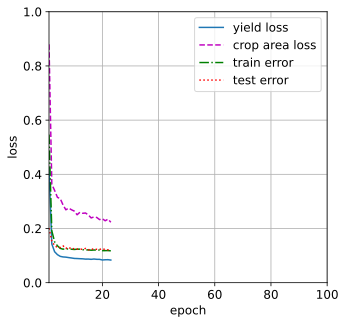

In [ ]:
if (test_env == 'notebook'):
  best_params['num_epochs'] = 100
  y_num_id_df = combined_dfs['LABEL_NUMERIC_IDS']
  x_num_id_df = combined_dfs['INPUT_NUMERIC_IDS']
  net, preds_l, preds_h, valid_nrmse = evaluateOptimalHyperparameters(cyp_config,
                                                                      combined_dfs,
                                                                      country_years,
                                                                      best_params,
                                                                      is_validation=True,
                                                                      early_stopping=True,
                                                                      visualize=True)
  print('Validation NRMSE:', round(100 * valid_nrmse, 2))
  low_res_pred_cols =["id0", "id_y", "FYEAR", "YIELD", "YIELD_PRED", "CROP_AREA", "CROP_AREA_PRED"]
  low_res_pred_df = pd.DataFrame(data=preds_l, columns=low_res_pred_cols)

  low_res_pred_df = low_res_pred_df.merge(y_num_id_df, on=['id0', 'id_y']).drop(columns=['id0', 'id_y'])
  low_res_pred_cols =["COUNTRY", low_res_id_col, "FYEAR", "YIELD", "YIELD_PRED", "CROP_AREA", "CROP_AREA_PRED"]
  low_res_pred_df = low_res_pred_df[low_res_pred_cols]

  high_res_pred_df = pd.DataFrame(data=preds_h, columns=["id_x", "FYEAR", "YIELD_PRED"])
  high_res_pred_df = high_res_pred_df.merge(x_num_id_df, on=['id_x'])
  if (label_spatial_level == 'NUTS2'):
    yield_sel_cols = ['id_x', 'FYEAR', 'YIELD']
    high_res_pred_df = high_res_pred_df.merge(nuts3_yield_df[yield_sel_cols], on=['id_x', "FYEAR"])
    high_res_pred_cols =["COUNTRY", low_res_id_col, high_res_id_col, "FYEAR", "YIELD", "YIELD_PRED"]
  else:
    high_res_pred_cols =["COUNTRY", low_res_id_col, high_res_id_col, "FYEAR", "YIELD_PRED"]

  high_res_pred_df = high_res_pred_df[high_res_pred_cols]
  countries = low_res_pred_df['COUNTRY'].unique()
  valid_info = '\nValidation Set NRMSEs'
  valid_info += '\n---------------------'
  for cn in countries:
    print('\n', crop, cn)
    valid_info += '\n' + crop + '(' + cn + ')'
    cn_low_res_df = low_res_pred_df[low_res_pred_df['COUNTRY'] == cn]
    cn_high_res_df = high_res_pred_df[high_res_pred_df['COUNTRY'] == cn]
    lres_nrmse = NormalizedRMSE(cn_low_res_df['YIELD'].values,
                                cn_low_res_df['YIELD_PRED'].values)
    print('Level y NRMSE:', lres_nrmse)
    valid_info += '\nLevel y NRMSE:' + str(lres_nrmse)
    print(cn_low_res_df.head(10))
    if (label_spatial_level == 'NUTS2'):
      hres_nrmse = NormalizedRMSE(cn_high_res_df['YIELD'].values,
                                  cn_high_res_df['YIELD_PRED'].values)
      print('\nLevel x NRMSE:', hres_nrmse)
      valid_info += '\nLevel x NRMSE:' + str(hres_nrmse)
      print(cn_high_res_df.head(10))

  log_fh.write(valid_info)

### Evaluate on test data

NRMSE: 0.1396
Test NRMSE: 13.96

 soft wheat DE
Level y NRMSE: 11.281173619014545
  COUNTRY NUTS2_ID   FYEAR  YIELD  YIELD_PRED  CROP_AREA  CROP_AREA_PRED
0      DE     DE11  2017.0   7.60    7.576547    87077.0    83729.328125
1      DE     DE11  2016.0   6.74    7.423351    92208.0    80908.765625
2      DE     DE11  2013.0   7.56    7.112234    95312.0    78159.281250
3      DE     DE11  2014.0   8.29    7.117731    93025.0    67796.929688
4      DE     DE11  2015.0   7.73    7.197464    95852.0    76455.500000
5      DE     DE12  2016.0   6.17    6.729160    40170.0    54230.273438
6      DE     DE12  2017.0   6.91    6.834273    37933.0    56013.847656
7      DE     DE12  2014.0   7.32    6.530761    40525.0    45798.085938
8      DE     DE12  2015.0   6.90    6.496878    41759.0    50462.500000
9      DE     DE12  2013.0   6.72    6.584461    41521.0    56269.621094

Level x NRMSE: 15.798565586884177
  COUNTRY NUTS2_ID NUTS3_ID   FYEAR  YIELD  YIELD_PRED
0      DE     DE11    DE1

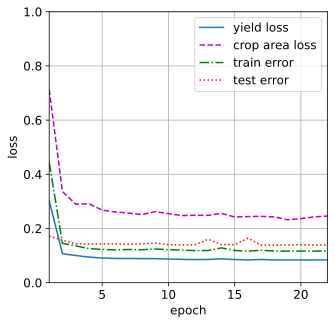

In [ ]:
if (test_env == 'notebook'):
  y_num_id_df = combined_dfs['LABEL_NUMERIC_IDS']
  x_num_id_df = combined_dfs['INPUT_NUMERIC_IDS']
  net, preds_l, preds_h, test_nrmse = evaluateOptimalHyperparameters(cyp_config,
                                                                     combined_dfs,
                                                                     country_years,
                                                                     best_params,
                                                                     is_validation=False,
                                                                     early_stopping=False,
                                                                     visualize=True)
  print('Test NRMSE:', round(100 * test_nrmse, 2))
  low_res_pred_cols =["id0", "id_y", "FYEAR", "YIELD", "YIELD_PRED", "CROP_AREA", "CROP_AREA_PRED"]
  low_res_pred_df = pd.DataFrame(data=preds_l, columns=low_res_pred_cols)

  low_res_pred_df = low_res_pred_df.merge(y_num_id_df, on=['id0', 'id_y']).drop(columns=['id0', 'id_y'])
  low_res_pred_cols =["COUNTRY", low_res_id_col, "FYEAR", "YIELD", "YIELD_PRED", "CROP_AREA", "CROP_AREA_PRED"]
  low_res_pred_df = low_res_pred_df[low_res_pred_cols]

  high_res_pred_df = pd.DataFrame(data=preds_h, columns=["id_x", "FYEAR", "YIELD_PRED"])
  high_res_pred_df = high_res_pred_df.merge(x_num_id_df, on=['id_x'])
  if (label_spatial_level == 'NUTS2'):
    yield_sel_cols = ['id_x', 'FYEAR', 'YIELD']
    high_res_pred_df = high_res_pred_df.merge(nuts3_yield_df[yield_sel_cols], on=['id_x', "FYEAR"])
    high_res_pred_cols =["COUNTRY", low_res_id_col, high_res_id_col, "FYEAR", "YIELD", "YIELD_PRED"]
  else:
    high_res_pred_cols =["COUNTRY", low_res_id_col, high_res_id_col, "FYEAR", "YIELD_PRED"]

  high_res_pred_df = high_res_pred_df[high_res_pred_cols]
  countries = low_res_pred_df['COUNTRY'].unique()
  test_info = '\nTest Set NRMSEs'
  test_info += '\n---------------'
  for cn in countries:
    print('\n', crop, cn)
    test_info += '\n' + crop + '(' + cn + ')'
    cn_low_res_df = low_res_pred_df[low_res_pred_df['COUNTRY'] == cn]
    cn_high_res_df = high_res_pred_df[high_res_pred_df['COUNTRY'] == cn]
    lres_nrmse = NormalizedRMSE(cn_low_res_df['YIELD'].values,
                                cn_low_res_df['YIELD_PRED'].values)
    print('Level y NRMSE:', lres_nrmse)
    test_info += '\nLevel y NRMSE:' + str(lres_nrmse)
    print(cn_low_res_df.head(10))
    if (label_spatial_level == 'NUTS2'):
      hres_nrmse = NormalizedRMSE(cn_high_res_df['YIELD'].values,
                                  cn_high_res_df['YIELD_PRED'].values)
      print('\nLevel x NRMSE:', hres_nrmse)
      test_info += '\nLevel x NRMSE:' + str(hres_nrmse)
      print(cn_high_res_df.head(10))

  output_path = cyp_config['output_path']
  high_res_pred_file = getPredictionFilename(cyp_config['crop'],
                                             cyp_config['use_yield_trend'],
                                             cyp_config['early_season_end_dekad'],
                                             country=country_code,
                                             spatial_level=cyp_config['input_spatial_level'],
                                             architecture=cyp_config['architecture'])
  high_res_pred_df.to_csv(output_path + '/' + high_res_pred_file + '.csv', index=False)

  low_res_pred_file = getPredictionFilename(cyp_config['crop'],
                                            cyp_config['use_yield_trend'],
                                            cyp_config['early_season_end_dekad'],
                                            country=country_code,
                                            spatial_level=cyp_config['label_spatial_level'],
                                            architecture=cyp_config['architecture'])

  low_res_pred_df.to_csv(output_path + '/' + low_res_pred_file + '.csv', index=False)

  log_fh.write(test_info)

### Evaluate Multiple Runs

#### Datasets

In [ ]:
test_fraction = cyp_config['test_fraction']
use_yield_trend = cyp_config['use_yield_trend']
early_season_end = cyp_config['early_season_end_dekad']
print_debug = cyp_config['debug_level'] > 1
num_valid_years = 5

scaler_args = {}
train_dataset = CYPMLDataset(combined_dfs, country_years,
                             yield_trend=use_yield_trend,
                             early_season_end=early_season_end,
                             is_train=True,
                             test_fraction=test_fraction,
                             num_folds=1, fold_iter=0,
                             num_valid_years=num_valid_years,
                             scaler_args=scaler_args,
                             print_debug=print_debug,
                             log_fh=log_fh)

valid_dataset = CYPMLDataset(combined_dfs, country_years,
                             yield_trend=use_yield_trend,
                             early_season_end=early_season_end,
                             is_train=False, is_validation=True,
                             test_fraction=test_fraction,
                             num_folds=1, fold_iter=0,
                             num_valid_years=num_valid_years,
                             scaler_args=scaler_args,
                             print_debug=print_debug,
                             log_fh=log_fh)

scaler_args = {}
train_dataset2 = CYPMLDataset(combined_dfs, country_years,
                              yield_trend=use_yield_trend,
                              early_season_end=early_season_end,
                              is_train=True,
                              test_fraction=test_fraction,
                              num_folds=1, fold_iter=0,
                              num_valid_years=0,
                              scaler_args=scaler_args,
                              print_debug=print_debug,
                              log_fh=log_fh)

test_dataset = CYPMLDataset(combined_dfs, country_years,
                            yield_trend=use_yield_trend,
                            early_season_end=early_season_end,
                            is_train=False, is_validation=False,
                            test_fraction=test_fraction,
                            num_folds=1, fold_iter=0,
                            num_valid_years=0,
                            scaler_args=scaler_args,
                            print_debug=print_debug,
                            log_fh=log_fh)

datasets = {
    'valid' : [train_dataset, valid_dataset],
    'test' : [train_dataset2, test_dataset]
}


----------------
Training data
----------------


Dekadal features: WLIM_YB, WLIM_YS, WLAI, TWC, RSM, TMAX, TMIN, TAVG, RAD, PREC, CWB, FAPAR
Other features: SM_WHC, AVG_ELEV, STD_ELEV, AVG_SLOPE, STD_SLOPE, AVG_FIELD_SIZE, STD_FIELD_SIZE, IRRIG_AREA_ALL, IRRIG_AREA90, CN_DE, CN_ES, CN_FR, CN_IT, AEZ_1761, AEZ_1810, AEZ_1842, AEZ_1845, AEZ_1892, AEZ_1932, AEZ_1957, AEZ_1960, AEZ_1976, AEZ_1984, AEZ_2030, AEZ_2034, AEZ_2057, AEZ_2075, AEZ_2107, AEZ_2135, AEZ_2137, AEZ_2150
Trend features: YIELD-5, YIELD-4, YIELD-3, YIELD-2, YIELD-1
Label columns: YIELD, CROP_AREA

DE Training years: 2004, 2005, 2006, 2007

ES Training years: 2003, 2004, 2005, 2006

FR Training years: 1999, 2000, 2001, 2002, 2003, 2004, 2005

IT Training years: 2000, 2001, 2002, 2003, 2004, 2005, 2006


Dekadal data: 1882, 30, 12
Other feature data: 357, 31
Trend feature data: 435, 5
Label data: 435, 5

------------------
Validation data
------------------


Dekadal features: WLIM_YB, WLIM_YS, WLAI, TWC, RSM, TMAX, TMIN

#### Training and Evaluation

In [ ]:
def trainAndTest(cyp_config, best_params,
                 train_dataset, test_dataset,
                 early_stopping=False,
                 visualize=False, country=None):
  """
  1. Evaluate on validation data: num_valid_years = 5
  2. Evaluate on test data: num_valid_years = 0.
  """
  loss = nn.MSELoss()
  num_epochs = best_params['num_epochs']
  architecture = cyp_config['architecture']

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1,
                                             shuffle=True, num_workers=2)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                            shuffle=False, num_workers=2)

  y_max = 1.0 # torch.max(train_dataset[0][3]).item()/2
  # train_dataset is : X_ts, X_rest, X_trend.
  # X_rest shape is (num_regions, variables). Skip TOTAL_AREA
  num_other_features = train_dataset[0][1].shape[1] - 1

  # X_trend shape is (trend_window)
  num_trend_features = train_dataset[0][2].shape[0]

  # time series (dekadal) data is [num_regions, num_dekads, num_indicators]
  num_ts_indicators = train_dataset[0][0].shape[2]
  ts_seq_len = train_dataset[0][0].shape[1]

  device = d2l.try_gpu()
  assert architecture in ['1DCNN', 'LSTM'], 'Architecture is not supported. Must be 1DCNN or LSTM.'
  if (architecture == '1DCNN'):
    net = CYP1DCNNModel(num_ts_indicators,
                        num_trend_features,
                        num_other_features,
                        ts_seq_len=ts_seq_len,
                        num_outputs=2)
  elif (architecture == 'LSTM'):
    net = CYPLSTMModel(num_ts_indicators,
                       num_trend_features,
                       num_other_features,
                       ts_seq_len=ts_seq_len,
                       num_outputs=2)

  net = net.to(device)
  trainer = torch.optim.Adam(net.parameters(), lr=best_params['lr'],
                             weight_decay=best_params['weight_decay'])

  test_nrmse, epochs_run = train(net, train_dataset, train_loader, test_loader,
                                 loss, best_params['loss_split'], trainer, num_epochs,
                                 early_stopping=early_stopping, device=device,
                                 country=country, visualize=visualize, ymax=y_max)

  if (early_stopping):
    best_params['num_epochs'] = epochs_run

  print('NRMSE:', round(test_nrmse, 4))
  preds_l, preds_h, test_nrmse = evaluatePredictions(net, test_loader, device)

  return net, preds_h, preds_l, test_nrmse

#### Evaluate Multiple Runs

In [ ]:

import pandas as pd
import statistics as stat

num_iters = 10
valid_set_lres_nrmses = {}
valid_set_hres_nrmses = {}
test_set_lres_nrmses = {}
test_set_hres_nrmses = {}

for i in range(1, num_iters + 1):
  """
  Evaluate on validation data with early stopping
  """
  iter_info = '\n' + 'Iteration ' + str(i)
  iter_info += '\n-------------------'
  print(iter_info)
  log_fh.write(iter_info)

  best_params['num_epochs'] = 100
  valid_info = '\n\nValidation Set Evaluation'
  valid_info += '\n----------------------------'
  print(valid_info)

  y_num_id_df = combined_dfs['LABEL_NUMERIC_IDS']
  x_num_id_df = combined_dfs['INPUT_NUMERIC_IDS']
  net, preds_h, preds_l, valid_nrmse = trainAndTest(cyp_config, best_params,
                                                    datasets['valid'][0], datasets['valid'][1],
                                                    early_stopping=True, visualize=False, country=country_code)

  valid_info = '\nValidation NRMSE:' + str(round(100 * valid_nrmse, 3))
  low_res_pred_cols =["id0", "id_y", "FYEAR", "YIELD", "YIELD_PRED", "CROP_AREA", "CROP_AREA_PRED"]
  pd_lres_cv_preds = pd.DataFrame(data=preds_l, columns=low_res_pred_cols)

  pd_lres_cv_preds = pd_lres_cv_preds.merge(y_num_id_df, on=['id0', 'id_y']).drop(columns=['id0', 'id_y'])
  low_res_pred_cols =["COUNTRY", low_res_id_col, "FYEAR", "YIELD", "YIELD_PRED", "CROP_AREA", "CROP_AREA_PRED"]
  pd_lres_cv_preds = pd_lres_cv_preds[low_res_pred_cols]

  pd_hres_cv_preds = pd.DataFrame(data=preds_h, columns=["id_x", "FYEAR", "YIELD_PRED"])
  pd_hres_cv_preds = pd_hres_cv_preds.merge(x_num_id_df, on=['id_x'])
  if (label_spatial_level == 'NUTS2'):
    yield_sel_cols = ['id_x', 'FYEAR', 'YIELD']
    pd_hres_cv_preds = pd_hres_cv_preds.merge(nuts3_yield_df[yield_sel_cols], on=['id_x', "FYEAR"])
    high_res_pred_cols =["COUNTRY", low_res_id_col, high_res_id_col, "FYEAR", "YIELD", "YIELD_PRED"]
  else:
    high_res_pred_cols =["COUNTRY", low_res_id_col, high_res_id_col, "FYEAR", "YIELD_PRED"]

  pd_hres_cv_preds = pd_hres_cv_preds[high_res_pred_cols]
  countries = pd_lres_cv_preds['COUNTRY'].unique()
  valid_info += '\nValidation Set NRMSEs'
  valid_info += '\n---------------------'
  for cn in countries:
    # print('\n', crop, cn)
    valid_info += '\n' + crop + '(' + cn + ')'
    cn_low_res_df = pd_lres_cv_preds[pd_lres_cv_preds['COUNTRY'] == cn]
    cn_high_res_df = pd_hres_cv_preds[pd_hres_cv_preds['COUNTRY'] == cn]
    lres_nrmse = NormalizedRMSE(cn_low_res_df['YIELD'].values,
                                cn_low_res_df['YIELD_PRED'].values)
    # print('Level y NRMSE:', lres_nrmse)
    valid_info += '\nLevel y NRMSE:' + str(lres_nrmse)
    if (cn in valid_set_lres_nrmses):
      nrmse_list = valid_set_lres_nrmses[cn]
    else:
      nrmse_list = []
 
    nrmse_list.append(lres_nrmse)
    valid_set_lres_nrmses[cn] = nrmse_list

    # print(cn_low_res_df.head(10))
    if (label_spatial_level == 'NUTS2'):
      hres_nrmse = NormalizedRMSE(cn_high_res_df['YIELD'].values,
                                  cn_high_res_df['YIELD_PRED'].values)
      # print('\nLevel x NRMSE:', hres_nrmse)
      valid_info += '\nLevel x NRMSE:' + str(hres_nrmse)
      # print(cn_high_res_df.head(10))
      if (cn in valid_set_hres_nrmses):
        nrmse_list = valid_set_hres_nrmses[cn]
      else:
        nrmse_list = []
 
      nrmse_list.append(hres_nrmse)
      valid_set_hres_nrmses[cn] = nrmse_list

  print(valid_info)
  log_fh.write(valid_info)

  """
  Evaluate on test data with early stopping epochs from above
  """
  y_num_id_df = combined_dfs['LABEL_NUMERIC_IDS']
  x_num_id_df = combined_dfs['INPUT_NUMERIC_IDS']
  test_info = '\n\nTest Set Evaluation'
  test_info += '\n----------------------------'
  print(test_info)
  net, preds_h, preds_l, test_nrmse = trainAndTest(cyp_config, best_params,
                                                   datasets['test'][0], datasets['test'][1],
                                                   early_stopping=False, visualize=False, country=country_code)
  test_info = '\nTest NRMSE: ' + str(round(100 * test_nrmse, 2))
  low_res_pred_cols =["id0", "id_y", "FYEAR", "YIELD", "YIELD_PRED", "CROP_AREA", "CROP_AREA_PRED"]
  pd_lres_test_preds = pd.DataFrame(data=preds_l, columns=low_res_pred_cols)

  pd_lres_test_preds = pd_lres_test_preds.merge(y_num_id_df, on=['id0', 'id_y']).drop(columns=['id0', 'id_y'])
  low_res_pred_cols =["COUNTRY", low_res_id_col, "FYEAR", "YIELD", "YIELD_PRED", "CROP_AREA", "CROP_AREA_PRED"]
  pd_lres_test_preds = pd_lres_test_preds[low_res_pred_cols]

  pd_hres_test_preds = pd.DataFrame(data=preds_h, columns=["id_x", "FYEAR", "YIELD_PRED"])
  pd_hres_test_preds = pd_hres_test_preds.merge(x_num_id_df, on=['id_x'])
  if (label_spatial_level == 'NUTS2'):
    yield_sel_cols = ['id_x', 'FYEAR', 'YIELD']
    pd_hres_test_preds = pd_hres_test_preds.merge(nuts3_yield_df[yield_sel_cols], on=['id_x', "FYEAR"])
    high_res_pred_cols =["COUNTRY", low_res_id_col, high_res_id_col, "FYEAR", "YIELD", "YIELD_PRED"]
  else:
    high_res_pred_cols =["COUNTRY", low_res_id_col, high_res_id_col, "FYEAR", "YIELD_PRED"]

  pd_hres_test_preds = pd_hres_test_preds[high_res_pred_cols]
  countries = pd_lres_test_preds['COUNTRY'].unique()
  test_info += '\nTest Set NRMSEs'
  test_info += '\n---------------------'
  for cn in countries:
    # print('\n', crop, cn)
    test_info += '\n' + crop + '(' + cn + ')'
    cn_low_res_df = pd_lres_test_preds[pd_lres_test_preds['COUNTRY'] == cn]
    cn_high_res_df = pd_hres_test_preds[pd_hres_test_preds['COUNTRY'] == cn]
    lres_nrmse = NormalizedRMSE(cn_low_res_df['YIELD'].values,
                                cn_low_res_df['YIELD_PRED'].values)
    # print('Level y NRMSE:', lres_nrmse)
    test_info += '\nLevel y NRMSE:' + str(lres_nrmse)
    # print(cn_low_res_df.head(10))
    if (cn in test_set_lres_nrmses):
      nrmse_list = test_set_lres_nrmses[cn]
    else:
      nrmse_list = []
 
    nrmse_list.append(lres_nrmse)
    test_set_lres_nrmses[cn] = nrmse_list

    if (label_spatial_level == 'NUTS2'):
      hres_nrmse = NormalizedRMSE(cn_high_res_df['YIELD'].values,
                                  cn_high_res_df['YIELD_PRED'].values)
      # print('\nLevel x NRMSE:', hres_nrmse)
      test_info += '\nLevel x NRMSE:' + str(hres_nrmse)
      # print(cn_high_res_df.head(10))
      if (cn in test_set_hres_nrmses):
        nrmse_list = test_set_hres_nrmses[cn]
      else:
        nrmse_list = []
 
      nrmse_list.append(hres_nrmse)
      test_set_hres_nrmses[cn] = nrmse_list

  print(test_info)
  log_fh.write(test_info)

  output_path = cyp_config['output_path']
  high_res_pred_file = getPredictionFilename(cyp_config['crop'],
                                             cyp_config['use_yield_trend'],
                                             cyp_config['early_season_end_dekad'],
                                             country=country_code,
                                             spatial_level=cyp_config['input_spatial_level'],
                                             architecture=cyp_config['architecture'])
  pd_hres_test_preds.to_csv(output_path + '/' + high_res_pred_file + '-' + str(i) + '.csv', index=False)

  low_res_pred_file = getPredictionFilename(cyp_config['crop'],
                                            cyp_config['use_yield_trend'],
                                            cyp_config['early_season_end_dekad'],
                                            country=country_code,
                                            spatial_level=cyp_config['label_spatial_level'],
                                            architecture=cyp_config['architecture'])

  pd_lres_test_preds.to_csv(output_path + '/' + low_res_pred_file + '-' + str(i) + '.csv', index=False)

valid_info = '\n\nAverage Validation Set NRMSEs'
valid_info += '\n----------------------------'
for cn in valid_set_lres_nrmses:
  cn_avg_lres_nrmse = round(stat.fmean(valid_set_lres_nrmses[cn]), 3)
  cn_avg_hres_nrmse = round(stat.fmean(valid_set_hres_nrmses[cn]), 3)
  valid_info += '\n' + crop + ', '  + cn + '(' + cyp_config['label_spatial_level'] + '): ' + str(cn_avg_lres_nrmse)
  valid_info += '\n' + crop + ', '  + cn + '(' + cyp_config['input_spatial_level'] + '): ' + str(cn_avg_hres_nrmse)

print(valid_info)
log_fh.write(valid_info)

test_info = '\n\nAverage Test Set NRMSEs'
test_info += '\n----------------------------'
for cn in test_set_lres_nrmses:
  cn_avg_lres_nrmse = round(stat.fmean(test_set_lres_nrmses[cn]), 3)
  cn_avg_hres_nrmse = round(stat.fmean(test_set_hres_nrmses[cn]), 3)
  test_info += '\n' + crop + ', '  + cn + '(' + cyp_config['label_spatial_level'] + '): ' + str(cn_avg_lres_nrmse)
  test_info += '\n' + crop + ', '  + cn + '(' + cyp_config['input_spatial_level'] + '): ' + str(cn_avg_hres_nrmse)

log_fh.write(test_info)
print(test_info)


Iteration 1
-------------------


Validation Set Evaluation
----------------------------
NRMSE: 0.1266

Validation NRMSE:12.655
Validation Set NRMSEs
---------------------
soft wheat(DE)
Level y NRMSE:11.724637376053066
Level x NRMSE:18.044598359535293
soft wheat(ES)
Level y NRMSE:21.253909624560702
Level x NRMSE:26.345081982416442
soft wheat(FR)
Level y NRMSE:8.900899631409343
Level x NRMSE:12.995312901957906
soft wheat(IT)
Level y NRMSE:17.301289110481395
Level x NRMSE:20.453443308763287


Test Set Evaluation
----------------------------
NRMSE: 0.141

Test NRMSE: 14.1
Test Set NRMSEs
---------------------
soft wheat(DE)
Level y NRMSE:12.635944314122039
Level x NRMSE:17.571843628560565
soft wheat(ES)
Level y NRMSE:22.113162367201337
Level x NRMSE:31.589012732826287
soft wheat(FR)
Level y NRMSE:12.559984883849141
Level x NRMSE:14.972598844972117
soft wheat(IT)
Level y NRMSE:17.14023355498051
Level x NRMSE:20.43041259723727

Iteration 2
-------------------


Validation Set Evaluation
-

### Close file handle

In [ ]:
log_fh.close()